In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,root_mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVR
import shap



scale_cols = [
        'AVG temperature', 'AVG rain', 'AVG fr_rain', 'AVG snow', 'AVG ice', 'AVG snow_depth',
        'AVG accumulated', 'AVG probability', 'AVG rate', 'AVG clouds', 'Physical capacity village level',
        'Physical capacity village level for hotel', 'Physical capacity village level for comfort',
        'Physical capacity village level for premium', 'Physical capacity village level for VIP', 
        'Rented villa nights before booking date on village level',
        'Rented villa nights before booking date on village level for hotel',
        'Rented villa nights before booking date on village level for comfort',
        'Rented villa nights before booking date on village level for premium',
        'Rented villa nights before booking date on village level for VIP',
        'Cottage rent per person', 'Lagged Cancellation Amount','Lagged cancellation insurance Amount','Lagged travel insurance Amount',
        'MIN temperature', 'MAX temperature', 'MIN rain', 'MAX rain',
        'MIN fr_rain', 'MAX fr_rain', 'MIN snow', 'MAX snow', 'MIN ice', 'MAX ice', 'MIN snow_depth', 
        'MAX snow_depth', 'MIN accumulated', 'MAX accumulated', 'MIN probability', 'MAX probability',
        'MIN rate', 'MAX rate'
    ]
weather_cols=['AVG temperature', 'AVG rain', 'AVG fr_rain', 'AVG snow', 'AVG ice', 'AVG snow_depth',
        'AVG accumulated', 'AVG probability', 'AVG rate', 'AVG clouds','MIN temperature', 'MAX temperature', 'MIN rain', 'MAX rain',
        'MIN fr_rain', 'MAX fr_rain', 'MIN snow', 'MAX snow', 'MIN ice', 'MAX ice', 'MIN snow_depth', 
        'MAX snow_depth', 'MIN accumulated', 'MAX accumulated', 'MIN probability', 'MAX probability',
        'MIN rate', 'MAX rate']
capacity_cols=[ 'Lagged Cancellation Amount','Lagged cancellation insurance Amount','Lagged travel insurance Amount',
               'Physical capacity village level','Physical capacity village level for hotel', 'Physical capacity village level for comfort',
            'Physical capacity village level for premium', 'Physical capacity village level for VIP', 
            'Rented villa nights before booking date on village level',
            'Rented villa nights before booking date on village level for hotel',
            'Rented villa nights before booking date on village level for comfort',
            'Rented villa nights before booking date on village level for premium',
            'Rented villa nights before booking date on village level for VIP',
            'Cottage rent per person']
cat_cols=['Holiday name', 'Leadtime','Booking day of week', 'Day of week visit',
        'Booking month', 'Month visit', 'Booking day date', 'Day visit date']
lag_cols=['Rented villa nights before booking date on village level',
       'Rented villa nights before booking date on village level for hotel',
       'Rented villa nights before booking date on village level for comfort',
       'Rented villa nights before booking date on village level for premium',
       'Rented villa nights before booking date on village level for VIP','Lagged Cancellation Amount', 'Lagged cancellation insurance Amount',
       'Lagged travel insurance Amount','AVG temperature', 'AVG rain', 'AVG fr_rain', 'AVG snow', 'AVG ice', 'AVG snow_depth',
        'AVG accumulated', 'AVG probability', 'AVG rate', 'AVG clouds','MIN temperature', 'MAX temperature', 'MIN rain', 'MAX rain',
        'MIN fr_rain', 'MAX fr_rain', 'MIN snow', 'MAX snow', 'MIN ice', 'MAX ice', 'MIN snow_depth', 
        'MAX snow_depth', 'MIN accumulated', 'MAX accumulated', 'MIN probability', 'MAX probability',
        'MIN rate', 'MAX rate']



# Splitting data in train, test and validation
def train_test_validation(df):
    split_date = '2023-09-30'
    split_date2 = '2022-10-01'
    split_date3 = '2022-09-30'
    train = df.loc[:split_date3]
    validation = df.loc[split_date2:split_date]
    test = df.loc[split_date:]

    return train,test,validation

#compares predicted and true values based on pandas describe
#extreme argument indicates what deviation of prediction and true value is classified as extreme
def comparison(y_test, y_pred, lead, compare, algo,X_test,extreme=0.2932751092707807):
    
    start_date= '2023-10-01'
    end_date= '2024-09-02'

    # Append new data if 'compare' already exists
    new_data = pd.DataFrame({
        'true': y_test,
        'predicted': y_pred,
        'Leadtime': lead,
        'Model': algo,
        'difference': y_test - y_pred  ,
        'negative': y_pred < 0,
        'extreme': (y_test - y_pred > extreme) | (y_test - y_pred < -extreme),
        'extreme threshold':extreme,
        'Date visit':X_test.index
    })
    
    compare = pd.concat([compare, new_data], ignore_index=True)
    
    
    return compare
#Fills missing values based on last observed value closest to date in specified limit, optionally can also fill with maximum value for that date
#column1 is the column with missing values
#column is the date column that the imputation is based on
#days is the upper limit that is used for looking up past values
def fill_values(df, column1, column2, days, maxi=False):
    # Convert the date column to datetime
    df[column2] = pd.to_datetime(df[column2], format='%d-%m-%Y', errors='raise')

    # Get indices of NaN values in column1
    na_indices = df[df[column1].isna()].index

    # Iterate through the indices with NaN values
    for index in na_indices:
        filled = False  # Track if we filled the NaN
        current_date = df.loc[index, column2]

        # Get rows for the same date
        same_date_rows = df[df[column2] == current_date]

        if maxi:
            # If maxi=True, fill with the max value from that day
            max_value = same_date_rows[column1].max()
            if not pd.isna(max_value):
                df.loc[index, column1] = max_value
                filled = True
        else:
            # Fill with the first non-NaN value from that day
            for _, row in same_date_rows.iterrows():
                if not pd.isna(row[column1]):
                    df.loc[index, column1] = row[column1]
                    filled = True
                    break

        # If not filled from the same date, check previous days
        if not filled and days > 0:
            for day in range(1, days + 1):
                prev_date = current_date - pd.Timedelta(days=day)
                prev_rows = df[df[column2] == prev_date]

                if maxi:
                    # Fill with max value from the previous date
                    max_value = prev_rows[column1].max()
                    if not pd.isna(max_value):
                        df.loc[index, column1] = max_value
                        filled = True
                        break
                else:
                    # Fill with first non-NaN value from previous dates
                    for _, row in prev_rows.iterrows():
                        if not pd.isna(row[column1]):
                            df.loc[index, column1] = row[column1]
                            filled = True
                            break
                if filled:
                    break
        
        # If no value was filled after checking the same and previous days
        if not filled:
            print(f"NaN found at index {index} for date {df.loc[index, column2]} could not be filled with any values.")

    return df
#Turns date visit, forecast dt iso, slice dt iso, and booking date into pandas date formats
def date_format():
    df['Date visit']=pd.to_datetime(df['Date visit'], format='%d-%m-%Y', errors='raise')
    df['Booking date'] = pd.to_datetime(df["Booking date"], format='%d-%m-%Y', errors='raise')
    df['forecast dt iso'] = pd.to_datetime(df["forecast dt iso"], format='%d-%m-%Y', errors='raise')
    df['slice dt iso'] = pd.to_datetime(df["slice dt iso"], format='%d-%m-%Y', errors='raise')
#Creates leadtime, day of week, month features for booking date and date visit
def feature_engineer():
    df['Leadtime']=(df['Date visit'] - df['Booking date']).dt.days.astype(int)
    df['Booking day of week']=df['Booking date'].dt.dayofweek
    df['Day of week visit']=df['Date visit'].dt.dayofweek
    df['Booking month']=df['Booking date'].dt.month
    df['Month visit']=df['Date visit'].dt.month 
    df['Booking day date']=df['Booking date'].dt.day
    df['Day visit date']=df['Date visit'].dt.day
#Filters df for leadtimes between 0 and up to 16 days
def leadfilter ():
    #Filtering for leadtime matching the weather forecast: Between 0 and 16 days
    df=df[df['Leadtime']>=0]
    df=df[df['Leadtime']<=16]
#Aggregated insurance counts are filled with 0, as nan means 0 for those columns
def impute():
    
    df[['Cancellation amount','Cancellation insurance', 'Travel insurance']] = df[['Cancellation amount','Cancellation insurance', 'Travel insurance']].fillna(0)     
# replaces commas with points and turns columns numeric
def make_numeric():
#Replace commas with points and turn object columns to numeric
    cols = [
        'MIN temperature', 'MAX temperature', 'AVG temperature',
        'MIN rain', 'MAX rain', 'AVG rain',
        'MIN fr_rain', 'MAX fr_rain', 'AVG fr_rain',
        'MIN snow', 'MAX snow', 'AVG snow',
        'MIN ice', 'MAX ice', 'AVG ice',
        'MIN snow_depth', 'MAX snow_depth', 'AVG snow_depth',
        'MIN accumulated', 'MAX accumulated', 'AVG accumulated',
        'MIN probability', 'MAX probability', 'AVG probability',
        'MIN rate', 'MAX rate', 'AVG rate',
        'AVG clouds','Cottage rent per person','Cottage rent VIP per person',
        'Cottage rent comfort per person','Cottage rent premium per person'

    ]



    def replace_commas(x):
        if isinstance(x, str):
            return x.replace(',', '.')
        return x

    # Apply replacement to relevant columns
    df[cols] = df[cols].apply(lambda col: col.map(replace_commas))
    df[cols] = df[cols].apply(pd.to_numeric, errors='raise')

# Function to propagate lagged values for a given test DataFrame and leadtime
def propagate_lag_values(test, leadtime, lag_cols=lag_cols):
    leadtime_values = test[test['Leadtime'] == leadtime][lag_cols]
    
    # Ensure dynamic alignment of values row-by-row
    for col in lag_cols:
        test[col] = test.index.map(leadtime_values[col].to_dict())
    test = test[test['Leadtime'] != leadtime].copy()
    return test


filepath='C:\\Users\\lsugg\\OneDrive - Pierre & Vacances - Centerparcs Group\\Desktop\\Sixth try.csv'
data=pd.read_csv(filepath,delimiter=';',low_memory=False)
df=pd.DataFrame(data)
#Some observations that are based on calculations in tableau have the '#DIV/0' adn get replaced with na
df.replace('#DIV/0', np.nan, inplace=True)

print(df.info())


date_format()
feature_engineer()
#df['Occupancy'] = df['Rented villa nights in date visit'] / df['Physical capacity village level']
# Filling missing holiday names based on holiday names for the same date visit
df = fill_values(df, 'Holiday name', 'Date visit', 0)
#Turning Holiday name categorical
print(np.unique(df['Holiday name']))
holiday_list = ['Autumn H', 'Christ_NY H', 'Core Summer H', 'Easter May H', 'Spring H', 'Summer H']
df['Holiday name'] = np.where(df['Holiday name'].isin(holiday_list), 1, 0)


#No forecast for this time
df = df[~(df['Date visit'] >= '2024-09-17')]
#Park was closed from 19.11.2018 until 06.12.2018
df = df[~((df['Date visit'] >= '2018-11-19') & (df['Date visit'] <= '2018-12-06'))]
ddf=df.copy()
df = df.sort_values(by=['Date visit', 'Booking date'], ascending=[True, True]).set_index('Date visit') 
impute()
make_numeric()
df.info()

c:\Users\lsugg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311413 entries, 0 to 311412
Data columns (total 67 columns):
 #   Column                                                                Non-Null Count   Dtype  
---  ------                                                                --------------   -----  
 0   Rented villa nights in date visit for VIP1                            311301 non-null  float64
 1   Rented villa nights in date visit for VIP                             311413 non-null  int64  
 2   Rented villa nights in date visit for premium1                        311299 non-null  float64
 3   Rented villa nights in date visit for premium                         311413 non-null  int64  
 4   Rented villa nights in date visit for comfort1                        311413 non-null  int64  
 5   Rented villa nights in date visit for comfort                         311413 non-null  int64  
 6   Rented villa nights in date visit for hotel1                          311255 non-nul

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [3]:

#Dropping observations without weather data
df=df.dropna(subset='forecast dt iso')

# Split overview
split_date = '2023-09-30' #end of training-validation data
split_date2 = '2022-10-01' # start of validation data
split_date3 = '2022-09-30' # end of training data
#5% na values for renting price
# Filling NA with training median to avoid data leakage
train_median = df['Cottage rent per person'].loc[:split_date3].median()
df['Cottage rent per person'] = df['Cottage rent per person'].fillna(train_median)
#Dropping temp columns
df=df.drop(['Rented villa nights',
       'Rented villa nights hotel', 'Rented villa nights comfort',
       'Rented villa nights premium', 'Rented villa nights VIP','Booking date', 'forecast dt iso', 'slice dt iso'],axis=1)
#Dropping all columns with missing values
df=df.dropna(axis=1)
#columns used for preprocessing in tableau
df=df.drop(['Rented villa nights in date visit for VIP1',
       'Rented villa nights in date visit for VIP',
       'Rented villa nights in date visit for premium1',
       'Rented villa nights in date visit for premium',
       'Rented villa nights in date visit for comfort1',
       'Rented villa nights in date visit for comfort',
       'Rented villa nights in date visit for hotel',
       'Rented villa nights in date visit1',
       'Rented villa nights in date visit'],axis=1)
def create_lag():

       # Create a lagged version of 'Cancellation amount' by shifting within groups
       df['Lagged Cancellation Amount'] = df.groupby(df.index)['Cancellation amount'].shift(1)
       # Compute the running sum of the lagged values
       df['Lagged Cancellation Amount'] = df.groupby(df.index)['Lagged Cancellation Amount'].cumsum().fillna(0)

       # Create a lagged version of 'cancellation insurance amount' by shifting within groups
       df['Lagged cancellation insurance Amount'] = df.groupby(df.index)['Cancellation insurance'].shift(1)
       # Compute the running sum of the lagged values
       df['Lagged cancellation insurance Amount'] = df.groupby(df.index)['Lagged cancellation insurance Amount'].cumsum().fillna(0)

       # Create a lagged version of 'travel insurance amount' by shifting within groups
       df['Lagged travel insurance Amount'] = df.groupby(df.index)['Travel insurance'].shift(1)
       # Compute the running sum of the lagged values
       df['Lagged travel insurance Amount'] = df.groupby(df.index)['Lagged travel insurance Amount'].cumsum().fillna(0)
       for col in weather_cols:
              df[col]=df.groupby(df.index)[col].shift(1)
create_lag()        

df['Occupancy']=df[df['Leadtime']==0]['Rented villa nights before booking date on village level']/df[df['Leadtime']==0]['Physical capacity village level']
print(df[['Leadtime', 'Cancellation amount','Lagged Cancellation Amount','Cancellation insurance','Lagged cancellation insurance Amount','Travel insurance','Lagged travel insurance Amount']].loc['2023-08-04'].head(17))
#Dropping features after lagged features have been created
df=df.drop(['Cancellation amount',	'Cancellation insurance',	'Travel insurance'],axis=1)
#Filter rows where 'Occupancy' is na
na_rows = df[df['Occupancy'].isna()]
#As missing rows are close to the end of provided data, there is no 0 lead time, thus the 17 rows are dropped
# Display the rows
print(na_rows[['Leadtime','Occupancy']].head(17))
df=df.dropna()
df.columns


            Leadtime  Cancellation amount  Lagged Cancellation Amount  \
Date visit                                                              
2023-08-04        16                  0.0                         0.0   
2023-08-04        15                  0.0                         0.0   
2023-08-04        14                  0.0                         0.0   
2023-08-04        13                  0.0                         0.0   
2023-08-04        12                  0.0                         0.0   
2023-08-04        11                  0.0                         0.0   
2023-08-04        10                  0.0                         0.0   
2023-08-04         9                  1.0                         0.0   
2023-08-04         8                  0.0                         1.0   
2023-08-04         7                  0.0                         1.0   
2023-08-04         6                  1.0                         1.0   
2023-08-04         5                  0.0          

Index(['Holiday name', 'Leadtime', 'MIN temperature', 'MAX temperature',
       'AVG temperature', 'MIN rain', 'MAX rain', 'AVG rain', 'MIN fr_rain',
       'MAX fr_rain', 'AVG fr_rain', 'MIN snow', 'MAX snow', 'AVG snow',
       'MIN ice', 'MAX ice', 'AVG ice', 'MIN snow_depth', 'MAX snow_depth',
       'AVG snow_depth', 'MIN accumulated', 'MAX accumulated',
       'AVG accumulated', 'MIN probability', 'MAX probability',
       'AVG probability', 'MIN rate', 'MAX rate', 'AVG rate', 'AVG clouds',
       'Physical capacity village level',
       'Physical capacity village level for hotel',
       'Physical capacity village level for comfort',
       'Physical capacity village level for premium',
       'Physical capacity village level for VIP',
       'Rented villa nights before booking date on village level',
       'Rented villa nights before booking date on village level for hotel',
       'Rented villa nights before booking date on village level for comfort',
       'Rented villa ni

In [3]:
df.shape

(22272, 51)

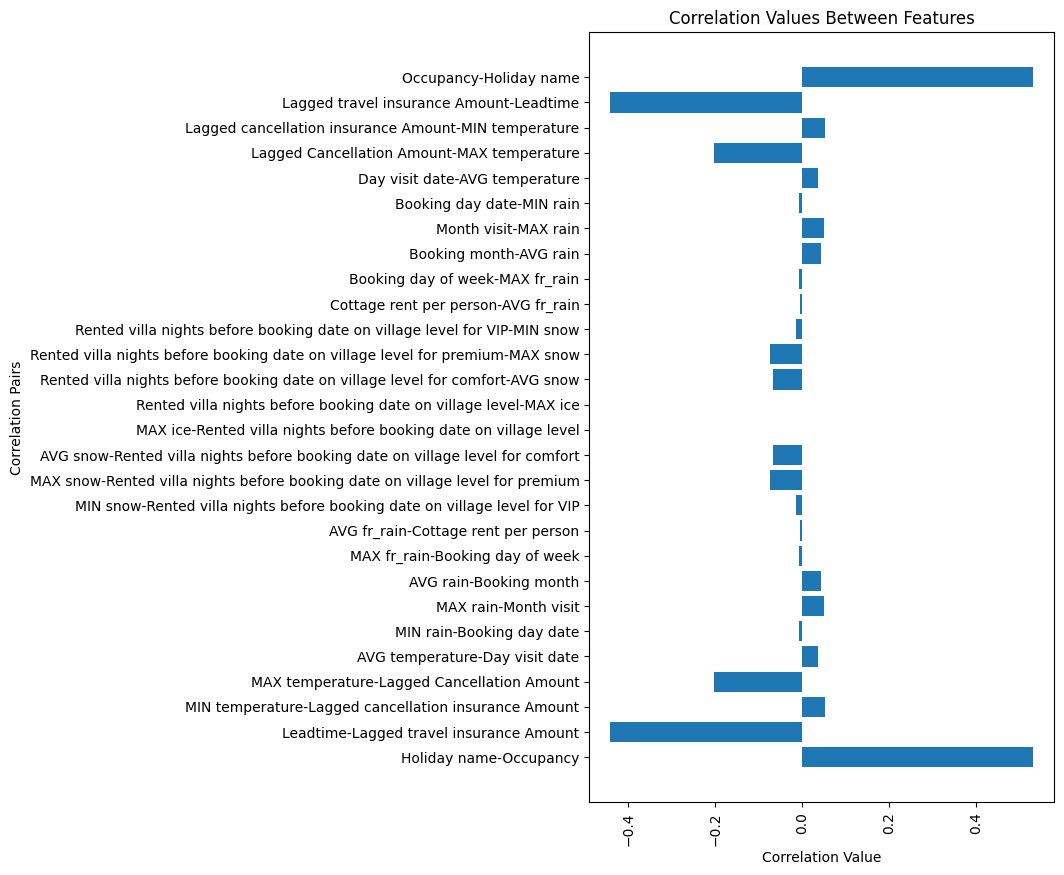

In [4]:
df_corr = df.corr()
df_corr=df_corr.drop(['Physical capacity village level',
       'Physical capacity village level for hotel',
       'Physical capacity village level for comfort',
       'Physical capacity village level for premium',
       'Physical capacity village level for VIP'],axis=1)
df_corr=df_corr.drop(['Physical capacity village level',
       'Physical capacity village level for hotel',
       'Physical capacity village level for comfort',
       'Physical capacity village level for premium',
       'Physical capacity village level for VIP'],axis=0)
useful_df = pd.DataFrame()

for row, col in zip(df_corr.index, df_corr.columns[::-1]):
    if row in weather_cols and col in weather_cols:
        continue
    elif row in capacity_cols and col in capacity_cols:
        continue
    elif row == col:
        continue
    else:
        # Extract the correlation value
        new_row = pd.DataFrame([df_corr.loc[row, col]], columns=[f'{row}-{col}'])
        useful_df = pd.concat([useful_df, new_row], axis=1)

#transposing the final df to have rows as correlations
useful_df = useful_df.transpose()
useful_df['Correlation']=useful_df[0].copy()
useful_df=useful_df.drop([0],axis=1)
useful_df.sort_values(by=['Correlation'])
useful_df=useful_df.dropna()
useful_df
plt.figure(figsize=(6,10))
plt.barh(useful_df.index, useful_df.iloc[:, 0])  
plt.xticks(rotation=90)  

plt.ylabel('Correlation Pairs')  
plt.xlabel('Correlation Value')  
plt.title('Correlation Values Between Features')  

plt.show()


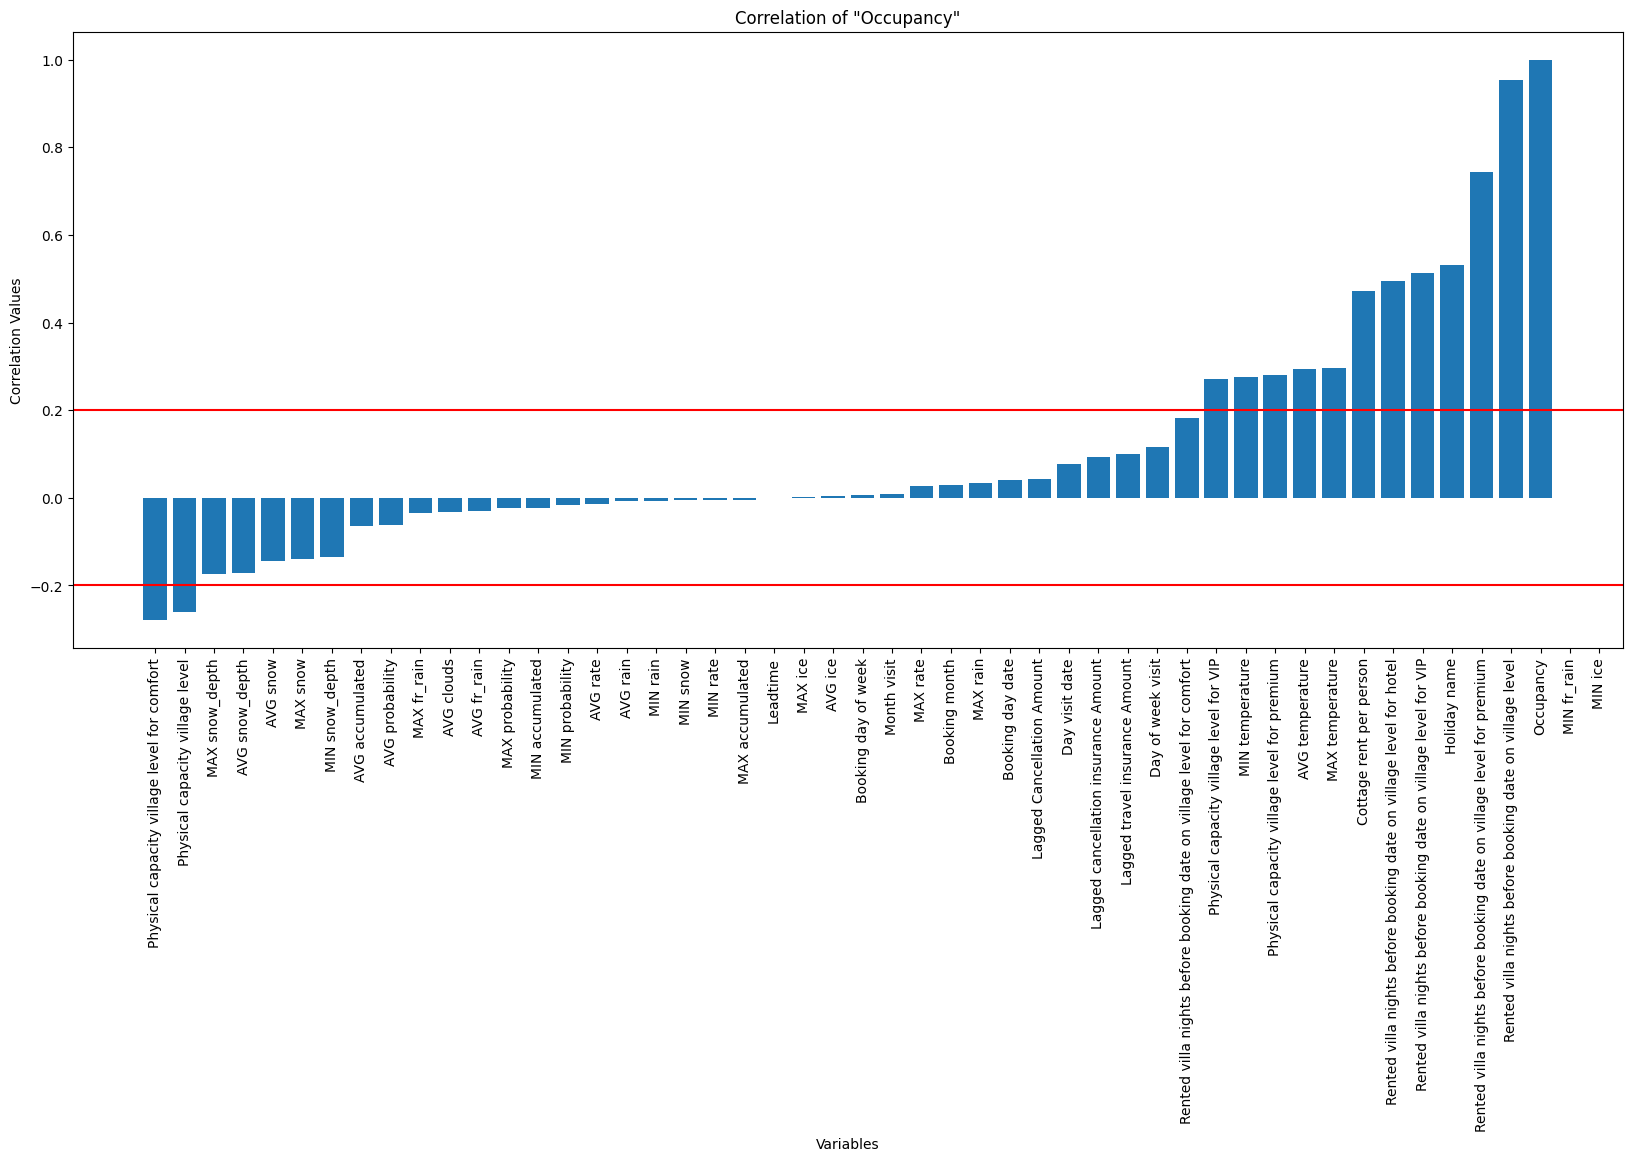

In [52]:
df_corr=df.corr()
df_corr=df_corr.sort_values(by=['Occupancy'])
plt.figure(figsize=(20,8))
bars = plt.bar(df_corr.index, df_corr['Occupancy'])

# Add annotations (index names) on top of each bar

plt.axhline(0.2,color='r')
plt.axhline(-0.2,color='r')
# Set labels and title
plt.xlabel('Variables')
plt.ylabel('Correlation Values')
plt.title('Correlation of "Occupancy"')

# Display the plot
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()


In [5]:
horizon14 = df[df['Leadtime'] <= 15].copy()
horizon7 = df[df['Leadtime'] <= 8].copy()
horizon5 = df[df['Leadtime'] <= 6].copy()
horizon1 = df[df['Leadtime'] <= 2].copy()
horizon14 = propagate_lag_values(horizon14, 15).dropna()
horizon7 = propagate_lag_values(horizon7, 8).dropna()
horizon5 = propagate_lag_values(horizon5, 6).dropna()
horizon1 = propagate_lag_values(horizon1, 2).dropna()
frames=[horizon14,horizon7,horizon5,horizon1]

In [54]:
df.to_csv('Prepped_data_occupancy.csv')

In [55]:
df=pd.DataFrame(pd.read_csv('C:\\Users\\lsugg\OneDrive - Pierre & Vacances - Centerparcs Group\\Desktop\\Thesis\\Prepped_data_occupancy.csv'))


<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\lsugg\AppData\Local\Temp\ipykernel_11360\1239310197.py:1: SyntaxWarning: invalid escape sequence '\O'
  df=pd.DataFrame(pd.read_csv('C:\\Users\\lsugg\OneDrive - Pierre & Vacances - Centerparcs Group\\Desktop\\Thesis\\Prepped_data_occupancy.csv'))


count    1403.000000
mean        0.777196
std         0.145458
min         0.299852
25%         0.696108
50%         0.803892
75%         0.888393
max         0.992515
Name: Occupancy, dtype: float64


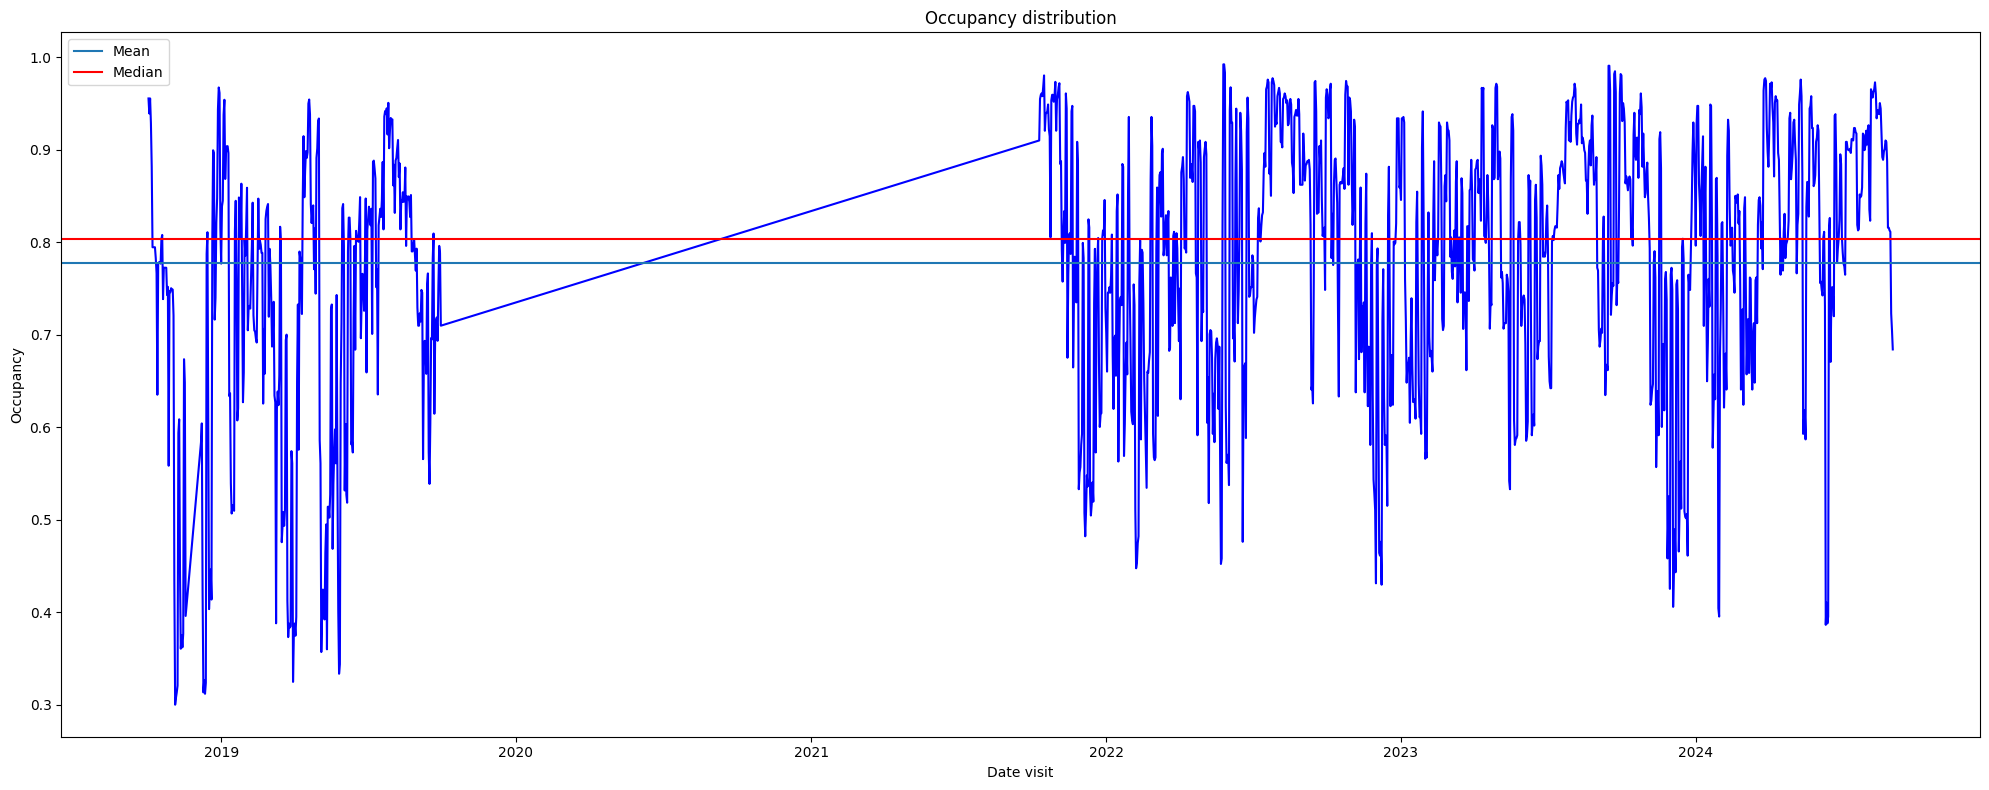

In [6]:


# Define lead colors for visualization
lead_colors = {1: 'blue'}

# Plotting target variable
plt.figure(figsize=(20, 8))

# Loop through unique lead times and plot each series
for lead in [1]:
    temp_df = df[df['Leadtime'] == lead]
    print(temp_df['Occupancy'].describe())
    # Group by date and calculate mean of 'Rented villa nights to come' per date
    mean_series = temp_df.groupby(temp_df.index)['Occupancy'].mean()
    plt.plot(temp_df['Occupancy'], color=lead_colors.get(lead, 'black'))

# Add legend and adjust layout
plt.axhline(temp_df['Occupancy'].mean(),label='Mean')
plt.axhline(temp_df['Occupancy'].median(),label='Median',color='r')
plt.legend()
plt.xlabel("Date visit")
plt.ylabel("Occupancy")
plt.title("Occupancy distribution")
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


In [7]:
# Splitting data in train, test and validation
split_date = '2023-09-30' #end of training-validation data
split_date2 = '2022-10-01' # start of validation data
split_date3 = '2022-09-30' # end of training data





def scree_PCA (train):
    leads=[1,5,7,1]
    
    scaler=RobustScaler()
    frame = train.copy()
    lead=frame['Leadtime'].max()
    
    train_scaled = scaler.fit_transform(frame[scale_cols])

    #PCA
    pca_all = PCA(n_components=10)

    #Fitting PCA on the entire scaled dataset
    pca_all.fit(train_scaled)

    #Creating a df for the explained variance ratio
    explained_variance_ratio = pd.DataFrame(pca_all.explained_variance_ratio_, 
                                            columns=['Explained Variance Ratio'])

    #Plotting the scree plot 
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), explained_variance_ratio.values, marker='o')
    plt.title(f'Scree Plot for PCA on All Scaled Columns with Leadtime {lead}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, 11))
    plt.grid()
    plt.show()



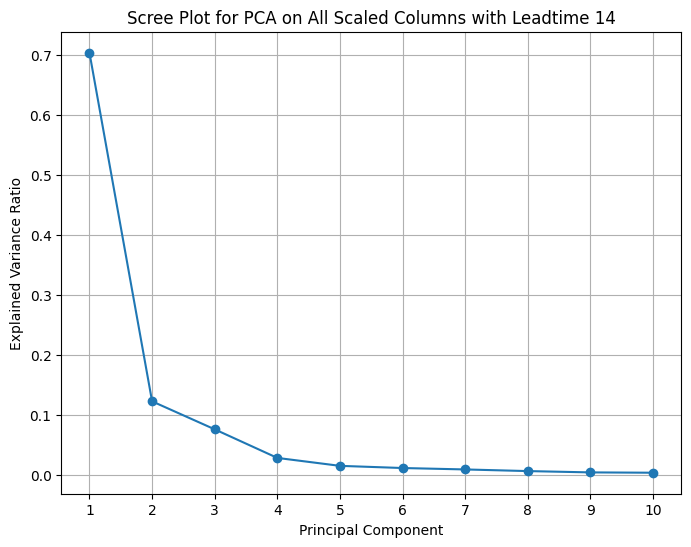

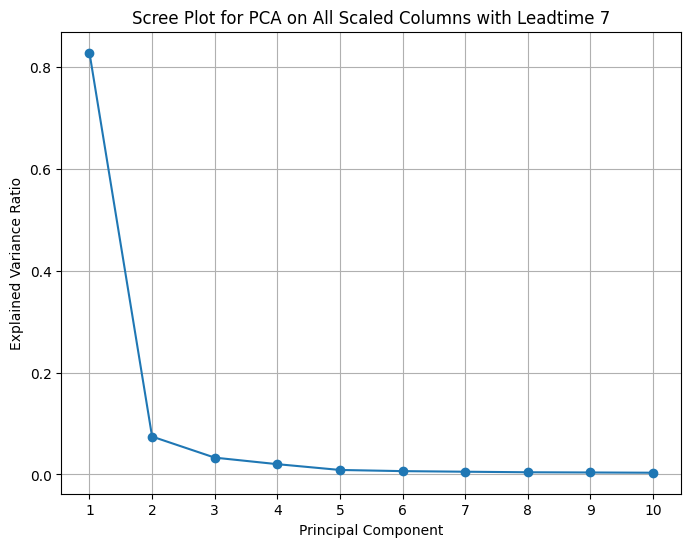

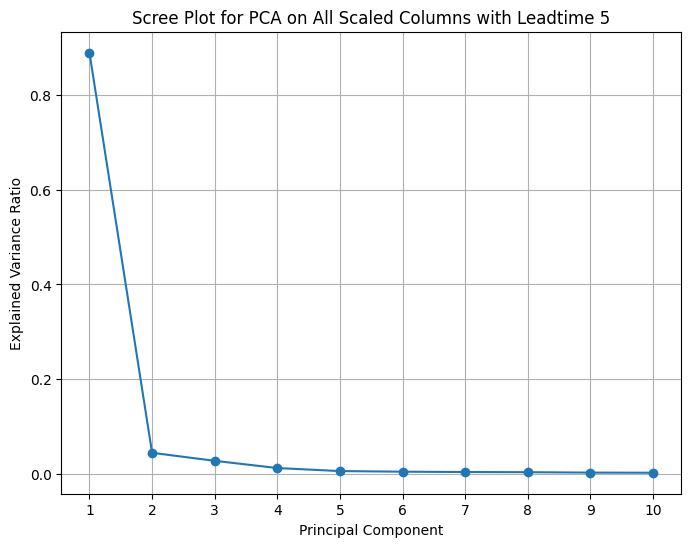

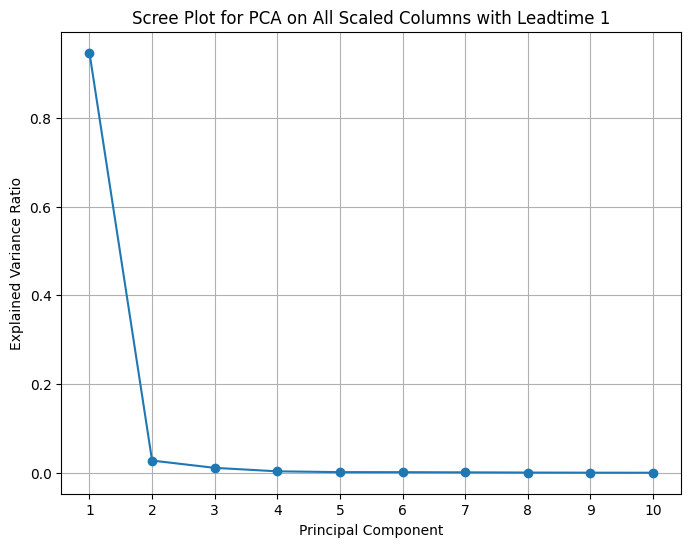

In [8]:
for frame in frames: 
    train = frame.loc[:split_date3]

    validation = frame.loc[split_date2:split_date]
    test = frame.loc[split_date:]
    scree_PCA(train)

In [10]:
#naive model uses prior year to predict test year
#
def naive_model(split_date = '2023-10-01'):
        #point forecast
    ddf=df.copy()
    ddf=ddf.drop(index='2024-02-29')
    lead16=ddf[ddf['Leadtime']<=14]
    lead7=ddf[ddf['Leadtime']<=7]
    lead5=ddf[ddf['Leadtime']<=5]
    lead1=ddf[ddf['Leadtime']<=1]
    maes={}
    compare = pd.DataFrame(columns=['true','predicted','Leadtime','difference','negative','Date visit','extreme'])

    frames=[lead16, lead7, lead5, lead1]
    for frame in frames:
        # Perform the time-based split
        #scale(frame,'Occupancy')
        lead=frame['Leadtime'].max()
        
        split_date = '2023-10-01'
        #remove leap year date
        
        test = frame.loc[split_date:]
        test=test[['Occupancy','Leadtime']]
        end='2024-09-01'
        test=test.loc[:end]
        split_date2 = '2022-10-01'
        train_naive=frame.loc[split_date2:]
        #Because that is where the test data stops
        split_date3='2023-09-01'
        train_naive=train_naive.loc[:split_date3]
        train_naive=train_naive[['Occupancy','Leadtime']]
        #train_naive now contains only the dates 1 year prior to the test data

        naive_pred=train_naive['Occupancy'].reset_index(drop=True)
        actual=test['Occupancy'].reset_index(drop=True)


        # Calculate metrics
        mape= np.round(mean_absolute_percentage_error(actual, naive_pred), 3)
        mae = np.round(mean_absolute_error(actual, naive_pred), 3)
        rmse = np.round(root_mean_squared_error(actual, naive_pred), 3)
        
        
        compare=comparison(actual,naive_pred,lead,compare,"Naive",test)
    
        maes.update({lead.astype(str):mae})
    print(f'Naive forecast from previous year')
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    
    print('MAPE:',mape)
    print('')
    print('')
    
    return compare
residuals_naive=naive_model()



Naive forecast from previous year
MAE:  0.094
RMSE:  0.126
MAPE: 0.127




C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\1289335392.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  ddf=ddf.drop(index='2024-02-29')
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\64783305.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_data], ignore_index=True)


In [11]:
residuals_naive

,true,predicted,Leadtime,difference,negative,Date visit,extreme,Model,extreme threshold
0,0.980539,0.965569,14,0.014970,False,2023-10-01,False,Naive,0.293275
1,0.980539,0.965569,14,0.014970,False,2023-10-01,False,Naive,0.293275
2,0.980539,0.965569,14,0.014970,False,2023-10-01,False,Naive,0.293275
3,0.980539,0.965569,14,0.014970,False,2023-10-01,False,Naive,0.293275
4,0.980539,0.965569,14,0.014970,False,2023-10-01,False,Naive,0.293275
...,...,...,...,...,...,...,...,...,...
10411,0.723054,0.868263,1,-0.145210,False,2024-08-30,False,Naive,0.293275
10412,0.705090,0.892216,1,-0.187126,False,2024-08-31,False,Naive,0.293275
10413,0.705090,0.892216,1,-0.187126,False,2024-08-31,False,Naive,0.293275
10414,0.684132,0.772455,1,-0.088323,False,2024-09-01,False,Naive,0.293275


In [13]:
capacity_only=['Occupancy','Holiday name',
 'Leadtime',
 'Booking day of week',
 'Day of week visit',
 'Booking month',
 'Month visit',
 'Booking day date',
 'Day visit date','Lagged Cancellation Amount',
 'Lagged cancellation insurance Amount',
 'Lagged travel insurance Amount',
 'Physical capacity village level',
 'Physical capacity village level for hotel',
 'Physical capacity village level for comfort',
 'Physical capacity village level for premium',
 'Physical capacity village level for VIP',
 'Rented villa nights before booking date on village level',
 'Rented villa nights before booking date on village level for hotel',
 'Rented villa nights before booking date on village level for comfort',
 'Rented villa nights before booking date on village level for premium',
 'Rented villa nights before booking date on village level for VIP',
 'Cottage rent per person']
scale_cols2 = [
        'Physical capacity village level',
        'Physical capacity village level for hotel', 'Physical capacity village level for comfort',
        'Physical capacity village level for premium', 'Physical capacity village level for VIP', 
        'Rented villa nights before booking date on village level',
        'Rented villa nights before booking date on village level for hotel',
        'Rented villa nights before booking date on village level for comfort',
        'Rented villa nights before booking date on village level for premium',
        'Rented villa nights before booking date on village level for VIP',
        'Cottage rent per person', 'Lagged Cancellation Amount','Lagged cancellation insurance Amount','Lagged travel insurance Amount'
        
    ]
capacity_14 = horizon14[capacity_only].copy()
capacity_7 = horizon7[capacity_only].copy()
capacity_5 = horizon5[capacity_only].copy()
capacity_1 = horizon1[capacity_only].copy()


In [14]:
#using two standard deviations for extreme prediction errors
double_standard=2*capacity_14['Occupancy'].std()
double_standard

np.float64(0.2932751092707807)

(10017, 23)


C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\64783305.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_data], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\4248788158.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masecompare = pd.concat([masecompare, new_row], ignore_index=True)


XGBRegressor
Test leadtime 14
MAE for XGBRegressor: 0.031
RMSE for XGBRegressor: 0.04
MAPE for XGBRegressor: 0.042
(5552, 23)
XGBRegressor
Test leadtime 7
MAE for XGBRegressor: 0.018
RMSE for XGBRegressor: 0.024
MAPE for XGBRegressor: 0.023
(4176, 23)
XGBRegressor
Test leadtime 5
MAE for XGBRegressor: 0.014
RMSE for XGBRegressor: 0.018
MAPE for XGBRegressor: 0.017
(1400, 23)
XGBRegressor
Test leadtime 1
MAE for XGBRegressor: 0.006
RMSE for XGBRegressor: 0.007
MAPE for XGBRegressor: 0.007
(10017, 23)
ridge regression
Test leadtime 14
MAE for ridge regression: 0.034
RMSE for ridge regression: 0.043
MAPE for ridge regression: 0.045
(5552, 23)
ridge regression
Test leadtime 7
MAE for ridge regression: 0.021
RMSE for ridge regression: 0.029
MAPE for ridge regression: 0.026
(4176, 23)
ridge regression
Test leadtime 5
MAE for ridge regression: 0.016
RMSE for ridge regression: 0.023
MAPE for ridge regression: 0.02
(1400, 23)
ridge regression
Test leadtime 1
MAE for ridge regression: 0.005
RMSE

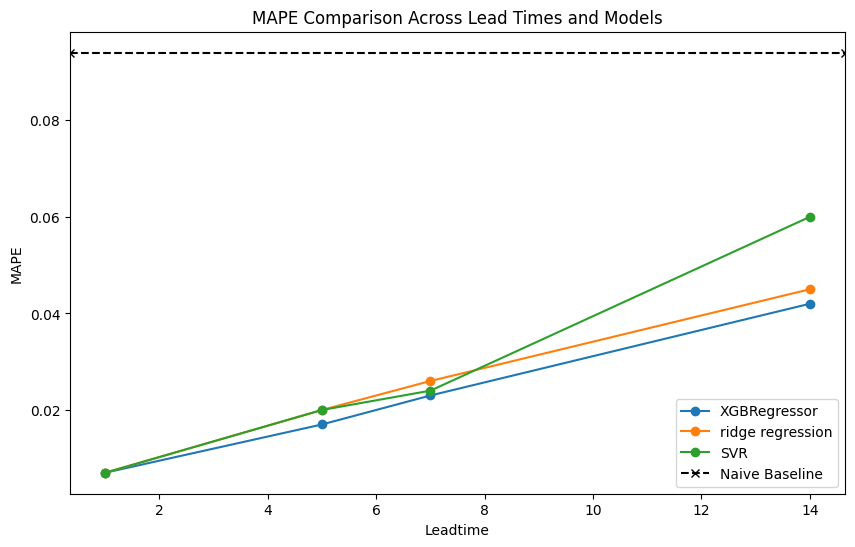

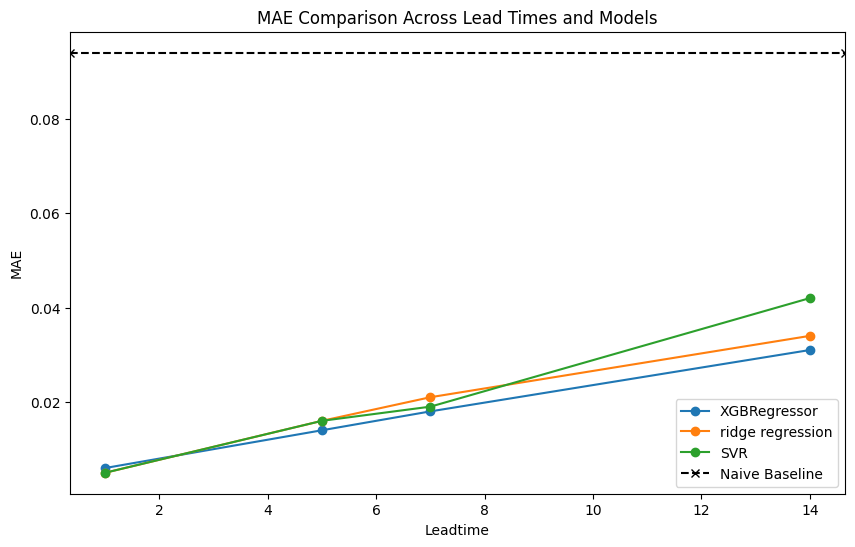

In [16]:
#Experiment 1
#no weather features model
def no_weather_model(split_date='2023-10-01', shapE=False,residual=False):
    
   

    frames= [capacity_14,capacity_7,capacity_5,capacity_1]
    compare = pd.DataFrame(columns=['true','predicted','Leadtime','Model','difference','negative','Date visit','extreme'])
    #model list
    models = ['XGBRegressor', 'ridge regression', 'SVR']
    #Setting the optimal parameters for each model and lead time
    optimal_params = {
        'XGBRegressor': {
            14: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}, 
            7: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},   
            5: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},  
            1: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}    
        },
        'ridge regression': {
            14: {'alpha': 5},  
            7: {'alpha': 5},  
            5: {'alpha': 5},   
            1: {'alpha': 5}    
        },
        'SVR': {
            14: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'},  # Best Validation MAPE: 0.058
            7: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'},  # Best Validation MAPE: 0.023
            5: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'},  # Best Validation MAPE: 0.018
            1: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}    # Best Validation MAPE: 0.006
        }
    }







 
    
    naive_maape=[0.123]
    naive=[0.094]
    naive_rmse=[0.126]
    
    masecompare = pd.DataFrame(columns=['Leadtime', 'Model','MAE','MAPE','RMSE','Approach'])

    for model in models:
        
        for t in frames:
            lead=t['Leadtime'].max()
            # Perform the time-based split
            # Prepare training data
            split_date3 = '2022-09-30'
            train = t.loc[:split_date3]
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
            test = t.loc[split_date:]  
            print(train.shape)
            # Prepare the test data
            X_test = test.drop(columns=['Occupancy'])
            y_test = test['Occupancy']
            if model == 'XGBRegressor':
                model_instance = xgb.XGBRegressor(**optimal_params[model][lead], enable_categorical=True)
            elif model == 'ridge regression':
                model_instance = Ridge(**optimal_params[model][lead])
            elif model == 'SVR':
                model_instance = SVR(**optimal_params[model][lead])
            model_instance.fit(X_train, y_train)
            # Predict on the test set
            y_pred = model_instance.predict(X_test)
           
            compare = comparison(y_test, y_pred, lead,compare,model,X_test,double_standard)
            

            mae = np.round(mean_absolute_error(y_test, y_pred), 3)
            rmse = np.round(root_mean_squared_error(y_test, y_pred), 3)
            
            mape=np.round(mean_absolute_percentage_error(y_test, y_pred), 3)
            print(model)
            print('Test leadtime',lead)
            print(f"MAE for {model}: {mae}")
            print(f"RMSE for {model}: {rmse}")
            print(f"MAPE for {model}: {mape}")
           
            
            new_row = pd.DataFrame([{'Leadtime': lead, 'Model': model,'MAE':mae,'RMSE':rmse,'MAPE':mape,'Approach':'No_weather'}])

# Concatenate the new row with the existing DataFrame
            masecompare = pd.concat([masecompare, new_row], ignore_index=True)
            

            # Measuring feature importance
            if shapE:
                if isinstance(model_instance, xgb.XGBRegressor):
                    explainer = shap.TreeExplainer(model_instance)
                    shap_values = explainer.shap_values(X_test)
                elif isinstance(model_instance, SVR):
                    continue  # Skip SHAP for SVR
                else:
                    explainer = shap.LinearExplainer(model_instance, X_train)
                    shap_values = explainer.shap_values(X_test)
                    
                plt.figure()
                shap.summary_plot(shap_values, X_test, show=False)
                plt.title(f"SHAP Leadtime for {model} (MAPE: {mape})")
                plt.show()
            
            # Print comparison of results
       
            if residual:
                # Stationarity of errors
                time_series = compare['difference'].copy()
                plt.figure(figsize=(10, 6))
                plt.plot(time_series, label=f"Errors forecast horizon {lead} for {model} (MAE: {mae})")
                
                # Rolling mean and variance
                rolling_mean = time_series.rolling(window=lead).mean()
                rolling_std = time_series.rolling(window=lead).std()

                # Plot rolling statistics
                plt.plot(rolling_mean, color='red', label='Rolling Mean')
                plt.plot(rolling_std, color='black', label='Rolling Std')
                plt.legend()
                plt.show()
    
# Plot MAAPE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAPE'], label=model_name, marker='o')
        
    plt.axhline( naive, label='Naive Baseline', marker='x', linestyle='--', color='black')     
    plt.title('MAPE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()
    # Plot MAE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAE'], label=model_name, marker='o')
        
    plt.axhline( naive, label='Naive Baseline', marker='x', linestyle='--', color='black')     
    plt.title('MAE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    return masecompare,compare
no_weather,residuals_no_weather=no_weather_model(shapE=False,residual=False)

In [64]:
no_weather

,Leadtime,Model,MAE,MAPE,RMSE,Approach
0,14,XGBRegressor,0.031,0.042,0.040,No_weather
1,7,XGBRegressor,0.018,0.023,0.024,No_weather
2,5,XGBRegressor,0.014,0.017,0.018,No_weather
3,1,XGBRegressor,0.006,0.007,0.007,No_weather
4,14,ridge regression,0.034,0.045,0.043,No_weather
5,7,ridge regression,0.021,0.026,0.029,No_weather
6,5,ridge regression,0.016,0.020,0.023,No_weather
7,1,ridge regression,0.005,0.007,0.008,No_weather
8,14,SVR,0.042,0.060,0.051,No_weather
9,7,SVR,0.019,0.024,0.026,No_weather


In [65]:
#Tuning for experiment 1 no weather features
def tuning_noweather( split_date='2023-10-01'):

    # Initialize the models
    models = [xgb.XGBRegressor(enable_categorical=True),
              Ridge(),
              SVR()]
    
    # Prepare training data
    
    frames = [capacity_14,capacity_7,capacity_5,capacity_1]
   
    
    for model in models:
        for frame in frames:
            lead=frame['Leadtime'].max()
            train,test,validation=train_test_validation(df=frame)
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
            
            y_val = validation['Occupancy']
            X_val = validation.drop(columns=['Occupancy'])

            if isinstance(model, xgb.XGBRegressor):
                param_grid = {
                    'n_estimators': [100,200,500],
                    'max_depth': [3, 5, 7, 14],
                    'learning_rate': [0.001, 0.01, 0.1]
                }
            elif isinstance(model, SVR):
                param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2],'kernel':['rbf']}
            else:
                param_grid = {'alpha': [0, 0.1, 1, 3, 5]}
        
        # Set up TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            # Initialize GridSearchCV with TimeSeriesSplit
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grid,
                                    scoring='neg_mean_absolute_percentage_error',  #MAAPE for scoring
                                    cv=tscv,
                                    n_jobs=-1)
            
            # Fit the grid search model
            grid_search.fit(X_train, y_train)

            # Get the best parameters and best score
            best_params = grid_search.best_params_
              
            # Initialize the model with the best parameters
            best_model = model.set_params(**best_params).fit(X_train, y_train)

            # Fit the best model 
            y_val_pred = best_model.predict(X_val)
            mape=np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)
            
            print(f"Best Parameters for Leadtime {lead} for {model.__class__.__name__}:", best_params)
            print("Best Validation MAPE Score:", mape)

tuning_noweather()

Best Parameters for Leadtime 14 for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.042
Best Parameters for Leadtime 7 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.024
Best Parameters for Leadtime 5 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Validation MAPE Score: 0.019
Best Parameters for Leadtime 1 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Validation MAPE Score: 0.006
Best Parameters for Leadtime 14 for Ridge: {'alpha': 5}
Best Validation MAPE Score: 0.044
Best Parameters for Leadtime 7 for Ridge: {'alpha': 5}
Best Validation MAPE Score: 0.024
Best Parameters for Leadtime 5 for Ridge: {'alpha': 5}
Best Validation MAPE Score: 0.019
Best Parameters for Leadtime 1 for Ridge: {'alpha': 5}
Best Validation MAPE Score: 0.005
Best Parameters for Leadtime 14 for SVR: {'C': 0.1, 'epsilon': 0.01, 

(10017, 51)
XGBRegressor
Test leadtime 14
MAE for XGBRegressor: 0.032
RMSE for XGBRegressor: 0.043
MAPE for XGBRegressor: 0.043
(5552, 51)


C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\64783305.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_data], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2173891318.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masecompare = pd.concat([masecompare, new_row], ignore_index=True)


XGBRegressor
Test leadtime 7
MAE for XGBRegressor: 0.019
RMSE for XGBRegressor: 0.025
MAPE for XGBRegressor: 0.024
(4176, 51)
XGBRegressor
Test leadtime 5
MAE for XGBRegressor: 0.013
RMSE for XGBRegressor: 0.017
MAPE for XGBRegressor: 0.017
(1400, 51)
XGBRegressor
Test leadtime 1
MAE for XGBRegressor: 0.006
RMSE for XGBRegressor: 0.007
MAPE for XGBRegressor: 0.007
(10017, 51)
ridge regression
Test leadtime 14
MAE for ridge regression: 0.032
RMSE for ridge regression: 0.042
MAPE for ridge regression: 0.043
(5552, 51)
ridge regression
Test leadtime 7
MAE for ridge regression: 0.018
RMSE for ridge regression: 0.024
MAPE for ridge regression: 0.023
(4176, 51)
ridge regression
Test leadtime 5
MAE for ridge regression: 0.013
RMSE for ridge regression: 0.018
MAPE for ridge regression: 0.017
(1400, 51)
ridge regression
Test leadtime 1
MAE for ridge regression: 0.006
RMSE for ridge regression: 0.007
MAPE for ridge regression: 0.007
(10017, 51)
SVR
Test leadtime 14
MAE for SVR: 0.045
RMSE for SV

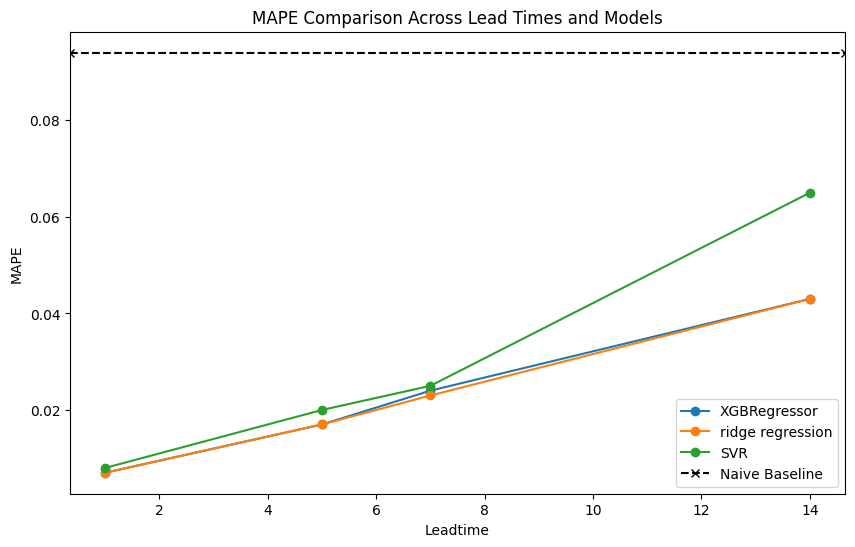

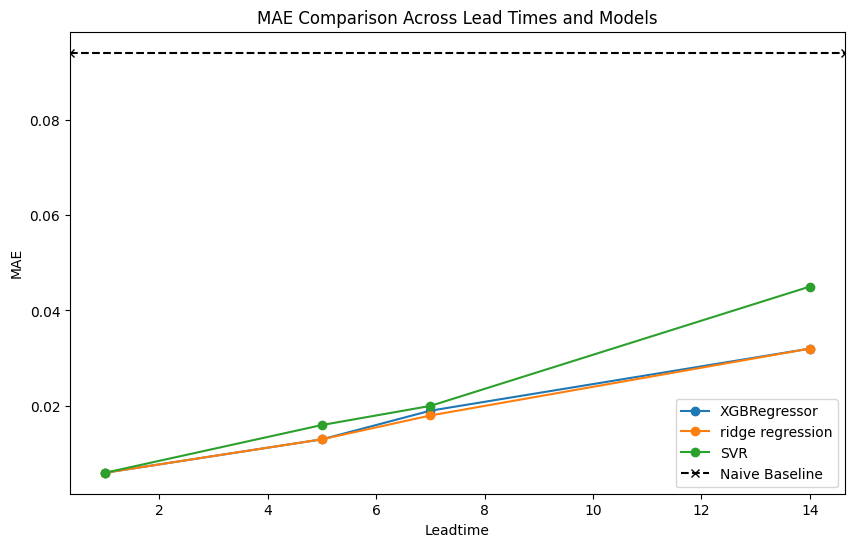

In [17]:
#Experiment 2
#unscaled model
def unscaled_model(split_date='2023-10-01', shapE=False,residual=False):
  
   

    
    compare = pd.DataFrame(columns=['true','predicted','Leadtime','Model','difference','negative','Date visit','extreme'])
    #model list
    models = ['XGBRegressor', 'ridge regression', 'SVR']
    # Setting the optimal parameters for each model and lead time
    optimal_params = {
        'XGBRegressor': {
            1: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
            5: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
            7: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500},
            14: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
        },
        'Ridge': {
            1: {'alpha': 0.1},
            5: {'alpha': 1},
            7: {'alpha': 0},
            14: {'alpha': 0.1},
        },
        'SVR': {
            1: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'},
            5: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'},
            7: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'},
            14: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'},
        }
    }





 
    
    naive_maape=[0.123]
    naive=[0.094]
    naive_rmse=[0.126]
    
    masecompare = pd.DataFrame(columns=['Leadtime', 'Model','MAE','MAPE','RMSE','Approach'])

    for model in models:
        
        for t in frames:
            lead=t['Leadtime'].max()
            # Perform the time-based split
            # Prepare training data
            split_date3 = '2022-09-30'
            train = t.loc[:split_date3]
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
            test = t.loc[split_date:]  
            print(train.shape)
            # Prepare the test data
            X_test = test.drop(columns=['Occupancy'])
            y_test = test['Occupancy']
            if model == 'XGBRegressor':
                model_instance = xgb.XGBRegressor(**optimal_params[model][lead], enable_categorical=True)
            elif model == 'Ridge':
                model_instance = Ridge(**optimal_params[model][lead])
            elif model == 'SVR':
                model_instance = SVR(**optimal_params[model][lead])
            model_instance.fit(X_train, y_train)
            # Predict on the test set
            y_pred = model_instance.predict(X_test)
           
            compare = comparison(y_test, y_pred, lead,compare,model,X_test,double_standard)
            

            mae = np.round(mean_absolute_error(y_test, y_pred), 3)
            rmse = np.round(root_mean_squared_error(y_test, y_pred), 3)
            #maape_score=np.round(maape(y_test, y_pred), 3)
            mape=np.round(mean_absolute_percentage_error(y_test, y_pred), 3)
            print(model)
            print('Test leadtime',lead)
            print(f"MAE for {model}: {mae}")
            print(f"RMSE for {model}: {rmse}")
            print(f"MAPE for {model}: {mape}")
           
            
            new_row = pd.DataFrame([{'Leadtime': lead, 'Model': model,'MAE':mae,'RMSE':rmse,'MAPE':mape,'Approach':'Unscaled'}])

# Concatenate the new row with the existing DataFrame
            masecompare = pd.concat([masecompare, new_row], ignore_index=True)
            

            # Measuring feature importance
            if shapE:
                if isinstance(model_instance, xgb.XGBRegressor):
                    explainer = shap.TreeExplainer(model_instance)
                    shap_values = explainer.shap_values(X_test)
                elif isinstance(model_instance, SVR):
                    continue  # Skip SHAP for SVR
                else:
                    explainer = shap.LinearExplainer(model_instance, X_train)
                    shap_values = explainer.shap_values(X_test)
                    
                plt.figure()
                shap.summary_plot(shap_values, X_test, show=False)
                plt.title(f"SHAP Leadtime for {model} (MAPE: {mape})")
                plt.show()
            
            # Print comparison of results
       
            if residual:
                # Stationarity of errors
                time_series = compare['difference'].copy()
                plt.figure(figsize=(10, 6))
                plt.plot(time_series, label=f"Errors forecast horizon {lead} for {model} (MAE: {mae}))")
                
                # Rolling mean and variance
                rolling_mean = time_series.rolling(window=lead).mean()
                rolling_std = time_series.rolling(window=lead).std()

                # Plot rolling statistics
                plt.plot(rolling_mean, color='red', label='Rolling Mean')
                plt.plot(rolling_std, color='black', label='Rolling Std')
                plt.legend()
                plt.show()
    
# Plot MAAPE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAPE'], label=model_name, marker='o')
        
    plt.axhline( naive, label='Naive Baseline', marker='x', linestyle='--', color='black')     
    plt.title('MAPE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()
    # Plot MAE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAE'], label=model_name, marker='o')
        
    plt.axhline( naive, label='Naive Baseline', marker='x', linestyle='--', color='black')     
    plt.title('MAE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    return masecompare,compare
unscaled,residuals_unscaled=unscaled_model()


In [67]:
residuals_unscaled

,true,predicted,Leadtime,Model,difference,negative,Date visit,extreme,extreme threshold
0,0.980539,0.954836,14,XGBRegressor,0.025702,False,2023-10-01,False,0.293275
1,0.980539,0.954836,14,XGBRegressor,0.025702,False,2023-10-01,False,0.293275
2,0.980539,0.954836,14,XGBRegressor,0.025702,False,2023-10-01,False,0.293275
3,0.980539,0.954836,14,XGBRegressor,0.025702,False,2023-10-01,False,0.293275
4,0.980539,0.954836,14,XGBRegressor,0.025702,False,2023-10-01,False,0.293275
...,...,...,...,...,...,...,...,...,...
31336,0.723054,0.692993,1,SVR,0.030061,False,2024-08-30,False,0.293275
31337,0.705090,0.703273,1,SVR,0.001816,False,2024-08-31,False,0.293275
31338,0.705090,0.703131,1,SVR,0.001959,False,2024-08-31,False,0.293275
31339,0.684132,0.687763,1,SVR,-0.003631,False,2024-09-01,False,0.293275


In [68]:
#Tuning for experiment 2 unscaled
def tuning_unscaled( split_date='2023-10-01'):

    # Initialize the models
    models = [xgb.XGBRegressor(enable_categorical=True),
              Ridge(),
              SVR()]
    
    # Prepare training data
    
    
   
    
    for model in models:
        for frame in frames:
            lead=frame['Leadtime'].max()
            train,test,validation=train_test_validation(df=frame)
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
            
            y_val = validation['Occupancy']
            X_val = validation.drop(columns=['Occupancy'])

            if isinstance(model, xgb.XGBRegressor):
                param_grid = {
                    'n_estimators': [100,200,500],
                    'max_depth': [3, 5, 7, 14],
                    'learning_rate': [0.001, 0.01, 0.1]
                }
            elif isinstance(model, SVR):
                param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2],'kernel':['rbf']}
            else:
                param_grid = {'alpha': [0, 0.1, 1, 3, 5]}
        
        # Set up TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            # Initialize GridSearchCV with TimeSeriesSplit
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grid,
                                    scoring='neg_mean_absolute_percentage_error',  #MAAPE for scoring
                                    cv=tscv,
                                    n_jobs=-1)
            
            # Fit the grid search model
            grid_search.fit(X_train, y_train)

            # Get the best parameters and best score
            best_params = grid_search.best_params_
              
            # Initialize the model with the best parameters
            best_model = model.set_params(**best_params).fit(X_train, y_train)

            # Fit the best model 
            y_val_pred = best_model.predict(X_val)
            mape=np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)
            
            print(f"Best Parameters for Leadtime {lead} for {model.__class__.__name__}:", best_params)
            print("Best Validation MAPE Score:", mape)

tuning_unscaled()

Best Parameters for Leadtime 14 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Validation MAPE Score: 0.044
Best Parameters for Leadtime 7 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.025
Best Parameters for Leadtime 5 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.019
Best Parameters for Leadtime 1 for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Validation MAPE Score: 0.006
Best Parameters for Leadtime 14 for Ridge: {'alpha': 0.1}
Best Validation MAPE Score: 0.044
Best Parameters for Leadtime 7 for Ridge: {'alpha': 0.1}
Best Validation MAPE Score: 0.024
Best Parameters for Leadtime 5 for Ridge: {'alpha': 1}
Best Validation MAPE Score: 0.019
Best Parameters for Leadtime 1 for Ridge: {'alpha': 0.1}
Best Validation MAPE Score: 0.006
Best Parameters for Leadtime 14 for SVR: {'C': 0.1, 'epsilon': 0

C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2377394054.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  highlights_mae = pd.concat([highlights_mae, temp_df.sort_values(by='MAE').drop_duplicates(['Model'])], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2377394054.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  highlights_MAPE = pd.concat([highlights_MAPE, temp_df.sort_values(by='MAPE').drop_duplicates(['Model'])], ignore_index=True)
C:\Users\lsugg\AppData\Lo

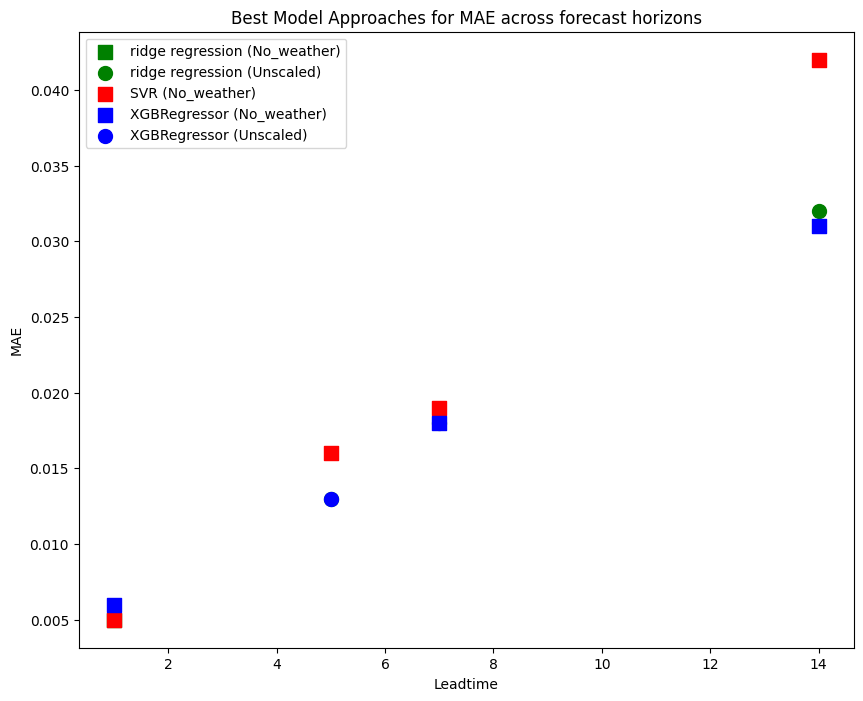

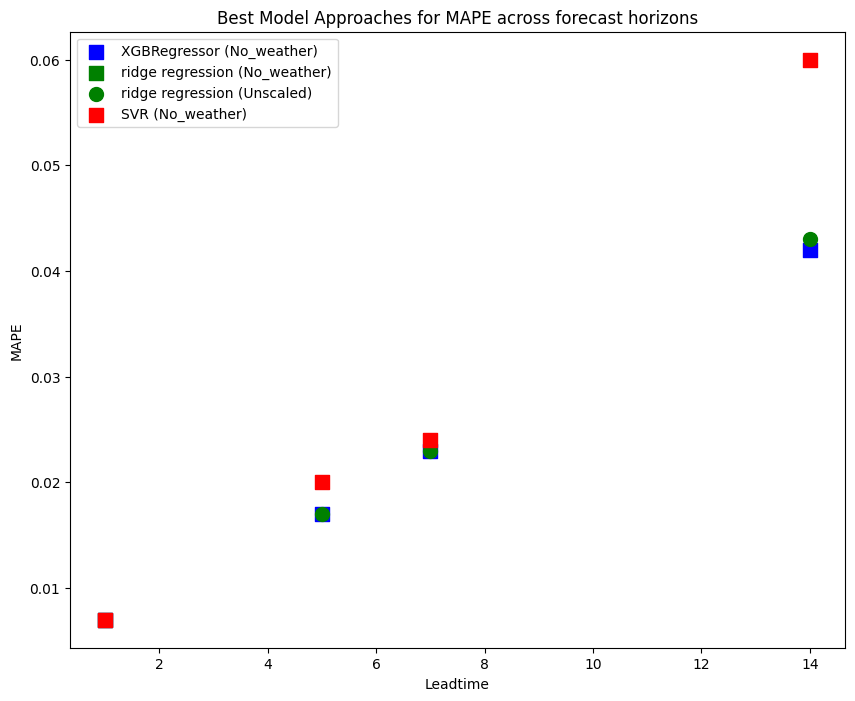

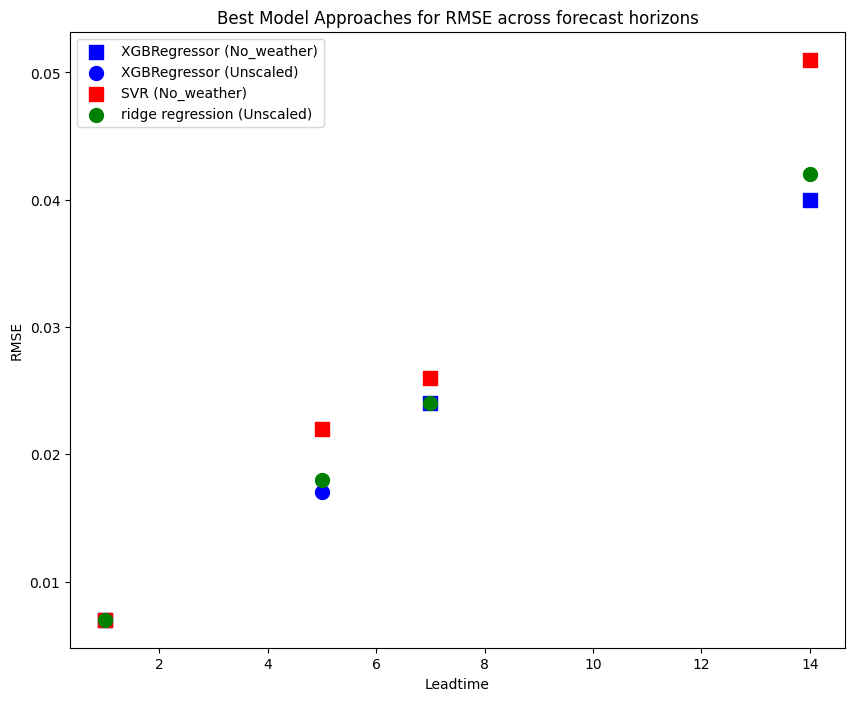

In [18]:
#Comparing models from experiment 1

def plot_best_model_approach(df1, df2,xp1=False,xp2=False,xp3=False):
    # Add an Approach column to distinguish between general and specific
    if xp1==True:
        df1['Approach'] = 'No_weather'
        df2['Approach'] = 'Unscaled'

    if xp2==True:
        df1['Approach'] = 'Scaled'
        df2['Approach'] = 'Unscaled'

    if xp3==True:
        df1['Approach'] = 'Blended'
        df2['Approach'] = 'Separate'
  


    # Concatenate the two DataFrames
    combined_df = pd.concat([df1,df2])
    leads = np.unique(combined_df['Leadtime'])
    
    # Prepare highlights DataFrames for each metric
    highlights_mae = pd.DataFrame(columns=combined_df.columns)
    highlights_MAPE = pd.DataFrame(columns=combined_df.columns)
    highlights_RMSE = pd.DataFrame(columns=combined_df.columns)
    # Identify best values for each metric
    for lead in leads:
        temp_df = combined_df[combined_df['Leadtime'] == lead]
        highlights_mae = pd.concat([highlights_mae, temp_df.sort_values(by='MAE').drop_duplicates(['Model'])], ignore_index=True)
        highlights_MAPE = pd.concat([highlights_MAPE, temp_df.sort_values(by='MAPE').drop_duplicates(['Model'])], ignore_index=True)
        highlights_RMSE = pd.concat([highlights_RMSE, temp_df.sort_values(by='RMSE').drop_duplicates(['Model'])], ignore_index=True)
    # Plot configurations
    if xp1:
        markers = {'No_weather': 's', 'Unscaled': 'o'}
    elif xp2:
        markers = {'Scaled': 's', 'Unscaled': 'o'}
    elif xp3:
        markers = {'Blended': 's', 'Separate': 'o'}
    colors = {'XGBRegressor': 'blue', 'ridge regression': 'green', 'SVR': 'red'}

    def plot_metric(metric, highlights_df, ylabel, baseline_key):
        plt.figure(figsize=(10, 8))
        for model in highlights_df['Model'].unique():
            model_data = highlights_df[highlights_df['Model'] == model]
            for approach in model_data['Approach'].unique():
                approach_data = model_data[model_data['Approach'] == approach]
                plt.scatter(
                    approach_data['Leadtime'], 
                    approach_data[metric], 
                    marker=markers[approach], 
                    color=colors[model], 
                    label=f'{model} ({approach})',
                    s=100
                )

        plt.title(f'Best Model Approaches for {metric} across forecast horizons')
        plt.xlabel('Leadtime')
        plt.ylabel(ylabel)
        plt.legend(loc='best')
        plt.show()

    # Plot the MAE and MAPE graphs
    plot_metric('MAE', highlights_mae, 'MAE', 'MAE')
    plot_metric('MAPE', highlights_MAPE, 'MAPE', 'MAPE')
    plot_metric('RMSE', highlights_RMSE, 'RMSE', 'RMSE')

    final_comparison=pd.concat([highlights_MAPE,highlights_mae,highlights_RMSE])
    final_comparison = final_comparison.drop_duplicates()
    final_comparison = final_comparison.dropna(axis=1)
    return final_comparison
# Use the function with your DataFrames
best_unscaled=plot_best_model_approach(no_weather, unscaled,True)

C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\64783305.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_data], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2096277278.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masecompare = pd.concat([masecompare, new_row], ignore_index=True)


XGBRegressor
Test leadtime 14
MAE for XGBRegressor: 0.028
RMSE for XGBRegressor: 0.039
MAPE for XGBRegressor: 0.036
XGBRegressor
Test leadtime 7
MAE for XGBRegressor: 0.017
RMSE for XGBRegressor: 0.024
MAPE for XGBRegressor: 0.022
XGBRegressor
Test leadtime 5
MAE for XGBRegressor: 0.013
RMSE for XGBRegressor: 0.019
MAPE for XGBRegressor: 0.017
XGBRegressor
Test leadtime 1
MAE for XGBRegressor: 0.005
RMSE for XGBRegressor: 0.007
MAPE for XGBRegressor: 0.007
ridge regression
Test leadtime 14
MAE for ridge regression: 0.028
RMSE for ridge regression: 0.038
MAPE for ridge regression: 0.037
ridge regression
Test leadtime 7
MAE for ridge regression: 0.017
RMSE for ridge regression: 0.024
MAPE for ridge regression: 0.022
ridge regression
Test leadtime 5
MAE for ridge regression: 0.013
RMSE for ridge regression: 0.018
MAPE for ridge regression: 0.016
ridge regression
Test leadtime 1
MAE for ridge regression: 0.005
RMSE for ridge regression: 0.007
MAPE for ridge regression: 0.007
SVR
Test leadt

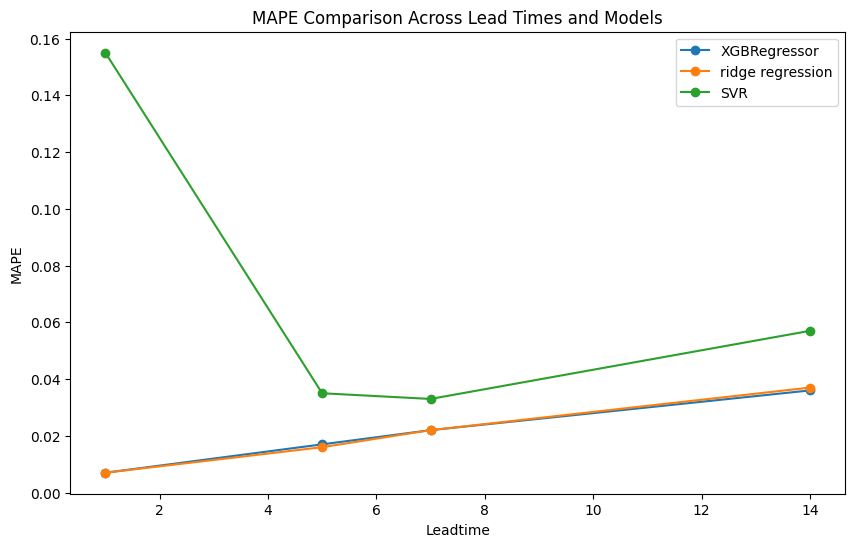

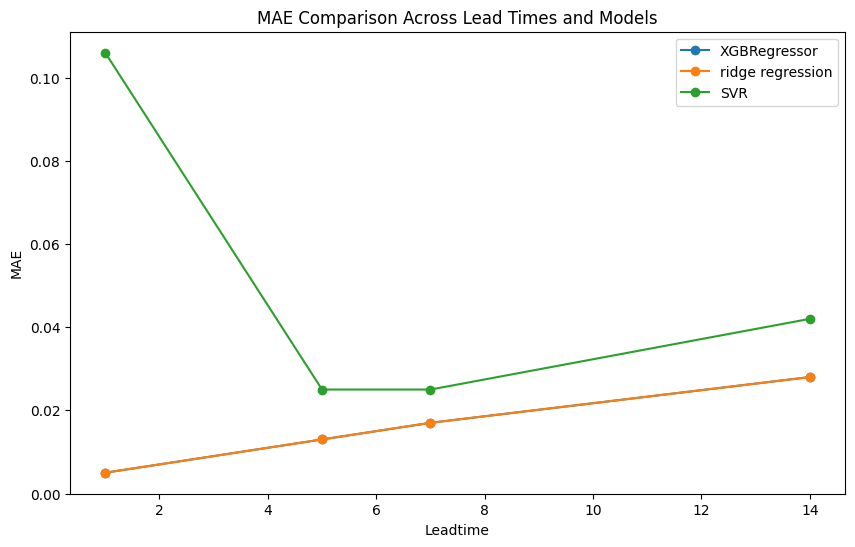

In [19]:
#Experiment 2
#Robust scaling

def scale_model(split_date='2023-10-01', shapE=False,residual=False):

    compare = pd.DataFrame(columns=['true','predicted','Leadtime','Model','difference','negative','Date visit','extreme'])
    
    
    #model list
    models = ['XGBRegressor', 'ridge regression', 'SVR']
    # Define the optimal parameters for each model and lead time
    optimal_params = {
        'XGBRegressor': {
            1: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
            5: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
            7: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500},
            14: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
        },
        'Ridge': {
            1: {'alpha': 3},
            5: {'alpha': 5},
            7: {'alpha': 5},
            14: {'alpha': 5}
        },
        'SVR': {
            1: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'},
            5: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'},
            7: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'},
            14: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}
        }
    }

    
    masecompare = pd.DataFrame(columns=['Leadtime', 'Model','MAE','RMSE','MAPE','Approach'])
    scaler=RobustScaler()
    for model in models:
        
        for t in frames:
            lead=t['Leadtime'].max()
            # Perform the time-based split
            # Prepare training data
            train = t.loc[:split_date]
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
                #Scaling all non categorical features
            X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
            
            test = t.loc[split_date:]  
            
            # Prepare the test data
            X_test = test.drop(columns=['Occupancy'])
            X_test[scale_cols] = scaler.transform(X_test[scale_cols])
            y_test = test['Occupancy']
            if model == 'XGBRegressor':
                model_instance = xgb.XGBRegressor(**optimal_params[model][lead], enable_categorical=True)
     
            elif model == 'Ridge':
                model_instance = Ridge(**optimal_params[model][lead])
            elif model == 'SVR':
                model_instance = SVR(**optimal_params[model][lead])
            model_instance.fit(X_train, y_train)
            # Predict on the test set
            y_pred = model_instance.predict(X_test)
           
            compare = comparison(y_test, y_pred, lead,compare,model,X_test,double_standard)
            

            mae = np.round(mean_absolute_error(y_test, y_pred), 3)
            rmse=np.round(root_mean_squared_error(y_test, y_pred), 3)
            #maape_score=np.round(maape(y_test, y_pred), 3)
            mape=np.round(mean_absolute_percentage_error(y_test, y_pred), 3)
            print(model)
            print('Test leadtime',lead)
            print(f"MAE for {model}: {mae}")
            print(f"RMSE for {model}: {rmse}")
            print(f"MAPE for {model}: {mape}")
           
            
            new_row = pd.DataFrame([{'Leadtime': lead, 'Model': model,'MAE':mae,'MAPE':mape,'Approach':'Scaled','RMSE':rmse}])

# Concatenate the new row with the existing DataFrame
            masecompare = pd.concat([masecompare, new_row], ignore_index=True)
            

            # Measuring feature importance
            if shapE:
                if isinstance(model_instance, xgb.XGBRegressor):
                    explainer = shap.TreeExplainer(model_instance)
                    shap_values = explainer.shap_values(X_test)
                elif isinstance(model_instance, SVR):
                    continue  # Skip SHAP for SVR
                else:
                    explainer = shap.LinearExplainer(model_instance, X_train)
                    shap_values = explainer.shap_values(X_test)
                    
                plt.figure()
                shap.summary_plot(shap_values, X_test, show=False)
                plt.title(f"SHAP for {model} (MAPE: {mape})")
                plt.show()
            
            # Print comparison of results
            
            #print(compare.describe(include='all'))
            if residual:
                # Stationarity of errors
                time_series = compare['difference'].copy()
                plt.figure(figsize=(10, 6))
                plt.plot(time_series, label=f"Errors forecast horizon {lead} for {model} (MAE: {mae})")
                
                # Rolling mean and variance
                rolling_mean = time_series.rolling(window=lead).mean()
                rolling_std = time_series.rolling(window=lead).std()

                # Plot rolling statistics
                plt.plot(rolling_mean, color='red', label='Rolling Mean')
                plt.plot(rolling_std, color='black', label='Rolling Std')
                plt.legend()
                plt.show()
    
# Plot MAAPE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAPE'], label=model_name, marker='o')
        
    
    plt.title('MAPE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()
    # Plot MAE comparison across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAE'], label=model_name, marker='o')
        
      
    plt.title('MAE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    return masecompare,compare
scaled_model,residuals_scale=scale_model()

In [71]:
residuals_scale


,true,predicted,Leadtime,Model,difference,negative,Date visit,extreme,extreme threshold
0,0.980539,0.972802,14,XGBRegressor,0.007737,False,2023-10-01,False,0.293275
1,0.980539,0.972802,14,XGBRegressor,0.007737,False,2023-10-01,False,0.293275
2,0.980539,0.972802,14,XGBRegressor,0.007737,False,2023-10-01,False,0.293275
3,0.980539,0.972802,14,XGBRegressor,0.007737,False,2023-10-01,False,0.293275
4,0.980539,0.972802,14,XGBRegressor,0.007737,False,2023-10-01,False,0.293275
...,...,...,...,...,...,...,...,...,...
31336,0.723054,0.811935,1,SVR,-0.088881,False,2024-08-30,False,0.293275
31337,0.705090,0.812445,1,SVR,-0.107355,False,2024-08-31,False,0.293275
31338,0.705090,0.812532,1,SVR,-0.107443,False,2024-08-31,False,0.293275
31339,0.684132,0.809843,1,SVR,-0.125711,False,2024-09-01,False,0.293275


In [72]:
#Tuning for experiment 2
#Tuning with robust scaling

def tuning_scaling( split_date='2023-10-01'):

    # Initialize the models
    models = [SVR(),xgb.XGBRegressor(enable_categorical=True),
              Ridge()]
    

    
    for model in models:
        for frame in frames:
           
            train,test,validation=train_test_validation(df=frame)
            scaler=RobustScaler()
            
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])

            y_val=validation['Occupancy']
            X_val=validation.drop(columns=['Occupancy'])

            #Scaling all non categorical features
            X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
            X_val[scale_cols] = scaler.transform(X_val[scale_cols])
            if isinstance(model, xgb.XGBRegressor):
                
                param_grid = {
                    'n_estimators': [100,200,500],
                    'max_depth': [3, 5, 7, 14],
                    'learning_rate': [0.001, 0.01, 0.1]
                }

              

            elif isinstance(model, SVR):
                param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2],'kernel':['rbf']}
            else:
                param_grid = {'alpha': [0, 0.1, 1, 3, 5]}
        
        # Set up TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            # Initialize GridSearchCV with TimeSeriesSplit
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grid,
                                    scoring='neg_mean_absolute_percentage_error',  #MAAPE for scoring
                                    cv=tscv,
                                    n_jobs=-1)

            # Fit the grid search model
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_
            best_model = model.set_params(**best_params).fit(X_train, y_train)
# Predict on the validation set using the best model
            y_val_pred = best_model.predict(X_val)

            # Get the best parameters and best score
            
            mape=np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)
            print('Leadtime:',frame['Leadtime'].max())
            print(f"Best Parameters for {model.__class__.__name__}:", best_params)
            print("Best Validation MAPE Score:", mape)
    
tuning_scaling()

Leadtime: 14
Best Parameters for SVR: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.051
Leadtime: 7
Best Parameters for SVR: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.027
Leadtime: 5
Best Parameters for SVR: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.026
Leadtime: 1
Best Parameters for SVR: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.017
Leadtime: 14
Best Parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Validation MAPE Score: 0.044
Leadtime: 7
Best Parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.025
Leadtime: 5
Best Parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.019
Leadtime: 1
Best Parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Validati

Scaled models
   Leadtime             Model    MAE   RMSE   MAPE Approach
0        14      XGBRegressor  0.028  0.039  0.036   Scaled
1         7      XGBRegressor  0.017  0.024  0.022   Scaled
2         5      XGBRegressor  0.013  0.019  0.017   Scaled
3         1      XGBRegressor  0.005  0.007  0.007   Scaled
4        14  ridge regression  0.028  0.038  0.037   Scaled
5         7  ridge regression  0.017  0.024  0.022   Scaled
6         5  ridge regression  0.013  0.018  0.016   Scaled
7         1  ridge regression  0.005  0.007  0.007   Scaled
8        14               SVR  0.042  0.061  0.057   Scaled
9         7               SVR  0.025  0.040  0.033   Scaled
10        5               SVR  0.025  0.049  0.035   Scaled
11        1               SVR  0.106  0.139  0.155   Scaled
Unscaled best
   Leadtime             Model    MAE   MAPE   RMSE    Approach
2         1               SVR  0.005  0.007  0.007  No_weather
5         5               SVR  0.016  0.020  0.022  No_weather
8  

C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2377394054.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  highlights_mae = pd.concat([highlights_mae, temp_df.sort_values(by='MAE').drop_duplicates(['Model'])], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\2377394054.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  highlights_MAPE = pd.concat([highlights_MAPE, temp_df.sort_values(by='MAPE').drop_duplicates(['Model'])], ignore_index=True)
C:\Users\lsugg\AppData\Lo

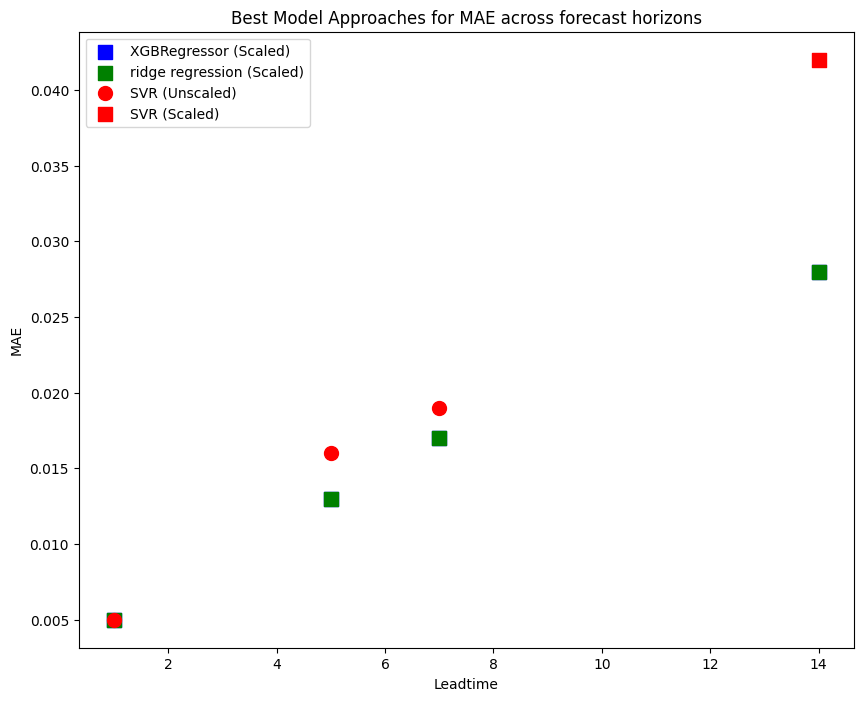

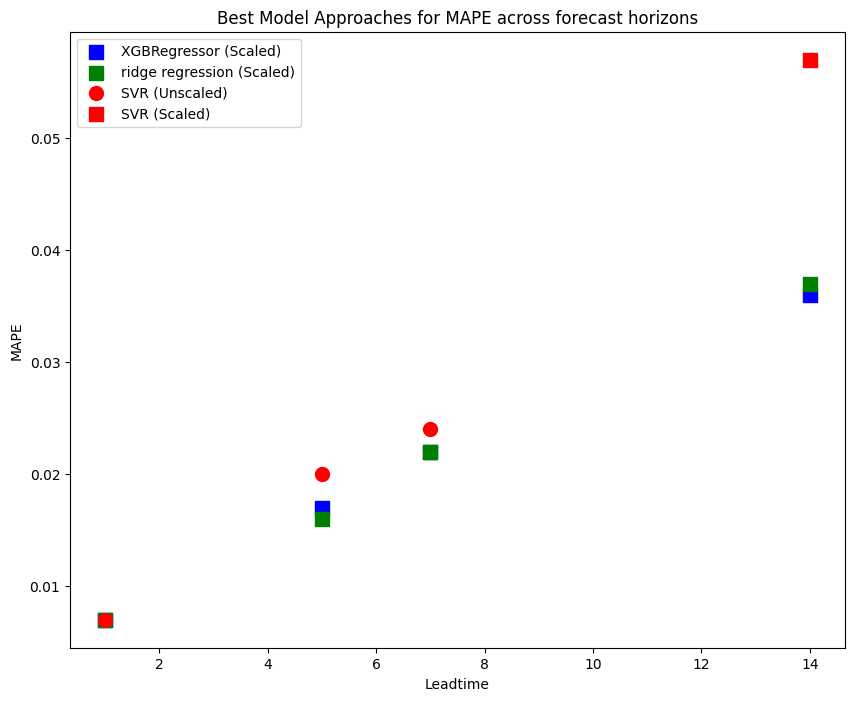

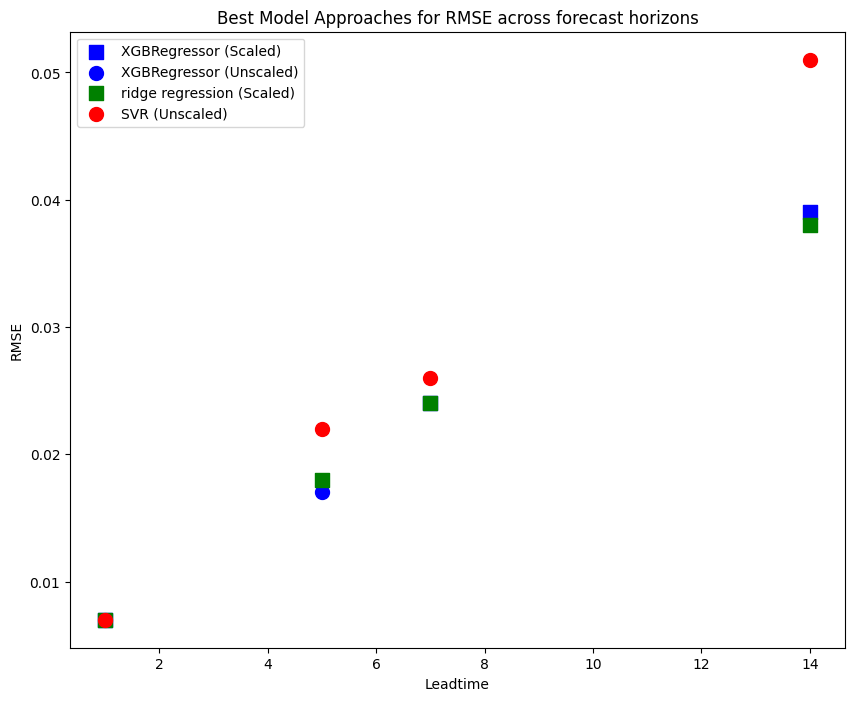

,Leadtime,Model,MAE,RMSE,MAPE,Approach
0,1,XGBRegressor,0.005,0.007,0.007,Scaled
1,1,ridge regression,0.005,0.007,0.007,Scaled
2,1,SVR,0.005,0.007,0.007,Unscaled
3,5,ridge regression,0.013,0.018,0.016,Scaled
4,5,XGBRegressor,0.013,0.019,0.017,Scaled
5,5,SVR,0.016,0.022,0.020,Unscaled
6,7,XGBRegressor,0.017,0.024,0.022,Scaled
7,7,ridge regression,0.017,0.024,0.022,Scaled
8,7,SVR,0.019,0.026,0.024,Unscaled
9,14,XGBRegressor,0.028,0.039,0.036,Scaled


In [20]:
#Comparing scaling with unscaled best models
print('Scaled models')
print(scaled_model)
print('Unscaled best')
print(best_unscaled.sort_values(by='Model'))
plot_best_model_approach(scaled_model,best_unscaled ,xp2=True)

C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\143237928.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  masecompare = pd.concat([masecompare, new_row], ignore_index=True)
C:\Users\lsugg\AppData\Local\Temp\ipykernel_22572\64783305.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_data], ignore_index=True)


Lead time: 14, Model: XGBRegressor
MAE: 0.088, MAPE: 0.117
Lead time: 7, Model: XGBRegressor
MAE: 0.081, MAPE: 0.108
Lead time: 5, Model: XGBRegressor
MAE: 0.098, MAPE: 0.131
Lead time: 1, Model: XGBRegressor
MAE: 0.098, MAPE: 0.13

Lead time: 14, Model: ridge regression
MAE: 0.092, MAPE: 0.125
Lead time: 7, Model: ridge regression
MAE: 0.094, MAPE: 0.126
Lead time: 5, Model: ridge regression
MAE: 0.097, MAPE: 0.132
Lead time: 1, Model: ridge regression
MAE: 0.091, MAPE: 0.123

Lead time: 14, Model: SVR
MAE: 0.099, MAPE: 0.136
Lead time: 7, Model: SVR
MAE: 0.096, MAPE: 0.131
Lead time: 5, Model: SVR
MAE: 0.101, MAPE: 0.136
Lead time: 1, Model: SVR
MAE: 0.1, MAPE: 0.135



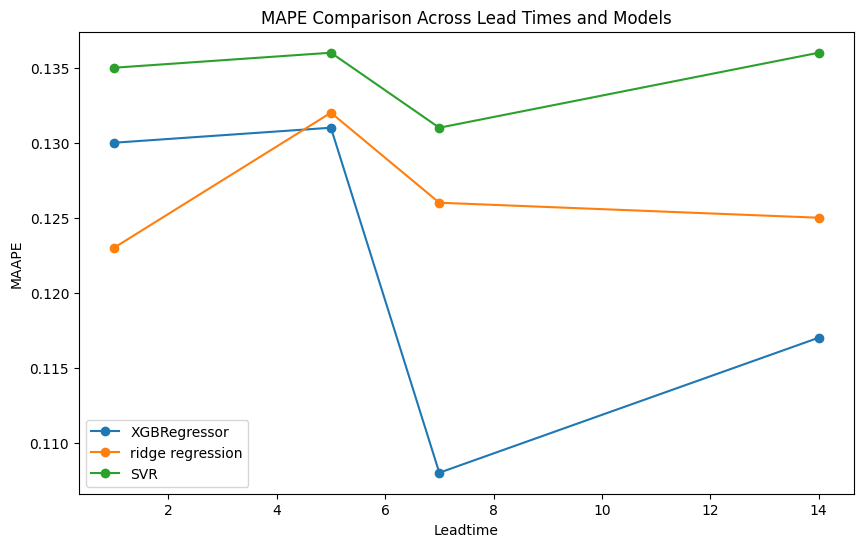

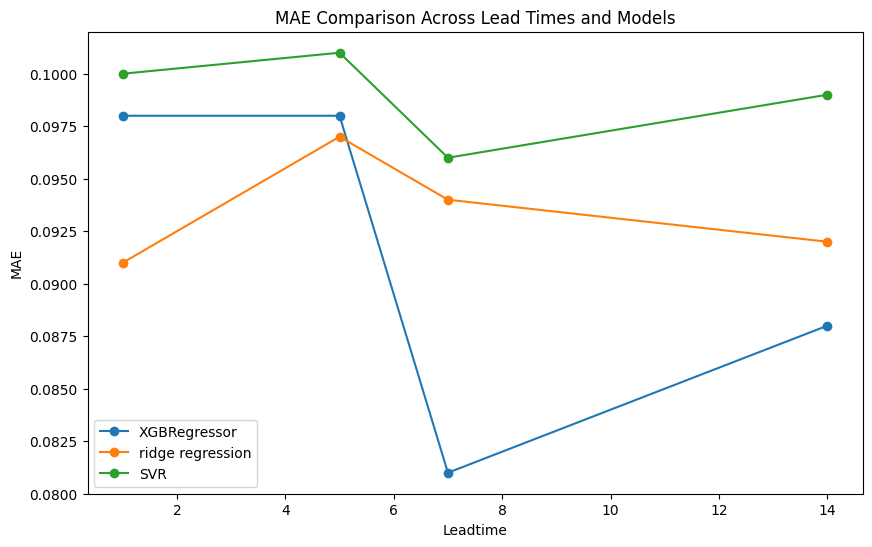

In [28]:
#Experiment 3
#different model for different leads, blended pca weather and capacity
def blended_pca(split_date='2023-10-01', shapE=False, residual=False):

    compare = pd.DataFrame(columns=['true','predicted','Leadtime','Model','difference','negative','Date visit','extreme'])

# Define the optimal parameters for each model and lead time
  
    optimal_params = {
        'XGBRegressor': {
            1: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
            5: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
            7: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500},
            14: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
        },
        'ridge regression': {
            1: {'alpha': 5},
            5: {'alpha': 3},
            7: {'alpha': 3},
            14: {'alpha': 5}
        },
        'SVR': {
            1: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'},
            5: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'},
            7: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'},
            14: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
        }
    }


    # setting up a dataframe to store performance metrics
    masecompare = pd.DataFrame(columns=['Leadtime', 'Model', 'MAE', 'MAPE',"RMSE",'Approach'])

    # Iterate through the models and lead times
    for model in ['XGBRegressor', 'ridge regression', 'SVR']:
        for frame in frames:
            lead_time = frame['Leadtime'].max()
            lead=lead_time
            # Assign model with optimal parameters for the given lead time
            if model == 'XGBRegressor':
                model_instance = xgb.XGBRegressor( **optimal_params[model][lead_time],enable_categorical=True)
            elif model == 'ridge regression':
                model_instance = Ridge(**optimal_params[model][lead_time])
            elif model == 'SVR':
                model_instance = SVR(**optimal_params[model][lead_time])
           

             
            split_date3 = '2022-09-30'
            train = frame.loc[:split_date3]
            test = frame.loc[split_date:]  
            y_train = train['Occupancy']
            X_train = train.drop(columns=['Occupancy'])
            # Prepare the test data
            X_test = test.drop(columns=['Occupancy'])
            a=X_test.copy()
            y_test = test['Occupancy']
                # Scale data separately for train and test sets
            scaler = RobustScaler()
            X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
            X_test[scale_cols] = scaler.transform(test[scale_cols])

         #Apply pca to train and test
            pca_total = PCA(n_components=2)
            X_train_pca = pd.DataFrame(pca_total.fit_transform(X_train[scale_cols]), columns=[f'PC_{i+1}' for i in range(2)])
            X_train = pd.concat([X_train_pca.reset_index(drop=True), X_train[cat_cols].reset_index(drop=True)], axis=1)
            
            X_test_pca=pd.DataFrame(pca_total.transform(X_test[scale_cols]), columns=[f'PC_{i+1}' for i in range(2)])
            X_test = pd.concat([X_test_pca.reset_index(drop=True), X_test[cat_cols].reset_index(drop=True)], axis=1)
    
            # Train the model
            model_instance.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model_instance.predict(X_test)

            # Evaluate metrics
            mae = np.round(mean_absolute_error(y_test, y_pred), 3)
            rmse= np.round(root_mean_squared_error(y_test, y_pred), 3)
            mape = np.round(mean_absolute_percentage_error(y_test, y_pred), 3)

            # Store results
            new_row = pd.DataFrame([{'Leadtime': lead_time, 'Model': model, 'MAE': mae, 'MAPE': mape,'RMSE':rmse,'Approach':'PCA'}])
            masecompare = pd.concat([masecompare, new_row], ignore_index=True)
            compare = comparison(y_test, y_pred, lead_time,compare,model,a,double_standard)
            # Print evaluation results
            print(f"Lead time: {lead_time}, Model: {model}")
            print(f"MAE: {mae}, MAPE: {mape}")
            if shapE==True:
          
                if isinstance(model_instance, xgb.XGBRegressor):
                    explainer = shap.TreeExplainer(model_instance)
                    shap_values = explainer.shap_values(X_test)
                elif isinstance(model_instance, SVR):
                    continue  # Skip SHAP for SVR
             
                elif isinstance(model_instance, Ridge):
                    explainer = shap.LinearExplainer(model_instance, X_train)
                    shap_values = explainer.shap_values(X_test)
      
                    
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_test, show=False)
                plt.title(f"SHAP Leadtime {lead_time} for {model} (MAPE: {mape})")
                plt.show()
            if residual:
                # Stationarity of errors
                time_series = compare['difference'].copy()
                plt.figure(figsize=(10, 6))
                plt.plot(time_series, label=f"Errors forecast horizon {lead} for {model} (MAE: {mae})")
                
                # Rolling mean and variance
                rolling_mean = time_series.rolling(window=lead).mean()
                rolling_std = time_series.rolling(window=lead).std()

                # Plot rolling statistics
                plt.plot(rolling_mean, color='red', label='Rolling Mean')
                plt.plot(rolling_std, color='black', label='Rolling Std')
                plt.legend()
                plt.show()
        print("")
    # Plot comparison of MAAPE across different lead times and models
    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAPE'], label=model_name, marker='o')
    
 
    plt.title('MAPE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAAPE')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    for model_name in masecompare['Model'].unique():
        subset = masecompare[masecompare['Model'] == model_name]
        plt.plot(subset['Leadtime'], subset['MAE'], label=model_name, marker='o')
    
   
    plt.title('MAE Comparison Across Lead Times and Models')
    plt.xlabel('Leadtime')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    return masecompare,compare
# Call the function
blended,residuals_blended=blended_pca()

In [78]:
residuals_blended

,true,predicted,Leadtime,Model,difference,negative,Date visit,extreme,extreme threshold
0,0.980539,0.827813,14,XGBRegressor,0.152726,False,2023-10-01,False,0.293275
1,0.980539,0.827813,14,XGBRegressor,0.152726,False,2023-10-01,False,0.293275
2,0.980539,0.827813,14,XGBRegressor,0.152726,False,2023-10-01,False,0.293275
3,0.980539,0.827813,14,XGBRegressor,0.152726,False,2023-10-01,False,0.293275
4,0.980539,0.827813,14,XGBRegressor,0.152726,False,2023-10-01,False,0.293275
...,...,...,...,...,...,...,...,...,...
31336,0.723054,0.840748,1,SVR,-0.117694,False,2024-08-30,False,0.293275
31337,0.705090,0.843872,1,SVR,-0.138782,False,2024-08-31,False,0.293275
31338,0.705090,0.837661,1,SVR,-0.132571,False,2024-08-31,False,0.293275
31339,0.684132,0.829467,1,SVR,-0.145335,False,2024-09-01,False,0.293275


In [79]:
#Tuning for experiment 3
# Tuning with pca 
def tuning_blended(df, n_components=2):
   

    # Initialize models
    models = [ SVR(), Ridge(),xgb.XGBRegressor(enable_categorical=True)]
    scaler = RobustScaler()
    # Set up TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    best_params = {model.__class__.__name__: {} for model in models}
    for frame in frames:
        train,test,validation=train_test_validation(df=frame)
        y_train = train['Occupancy']
        X_train = train.drop(columns=['Occupancy'])

        y_val=validation['Occupancy']
        X_val=validation.drop(columns=['Occupancy'])
            #Scaling all non categorical features
        X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
        X_val[scale_cols] = scaler.transform(X_val[scale_cols])
        #Apply pca
        pca_total = PCA(n_components=n_components)
        X_train_pca = pd.DataFrame(pca_total.fit_transform(X_train[scale_cols]), columns=[f'PC_{i+1}' for i in range(n_components)])
        X_train = pd.concat([X_train_pca.reset_index(drop=True), X_train[cat_cols].reset_index(drop=True)], axis=1)
        
        X_val_pca = pd.DataFrame(pca_total.transform(X_val[scale_cols]), columns=[f'PC_{i+1}' for i in range(n_components)])
        X_val = pd.concat([X_val_pca.reset_index(drop=True), X_val[cat_cols].reset_index(drop=True)], axis=1)


        for model in models:
            print(f"\nTuning Model: {model.__class__.__name__}")
            
            # Parameter grid
            if isinstance(model, xgb.XGBRegressor):
                param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 7,14], 'learning_rate': [0.001, 0.01, 0.1]}
            elif isinstance(model, SVR):
                param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2], 'kernel': ['rbf']}
            else:
                param_grid = {'alpha': [0, 0.1, 1, 3, 5]}

            # Set up TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            # Initialize GridSearchCV with TimeSeriesSplit
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grid,
                                    scoring='neg_mean_absolute_percentage_error',  #MAAPE for scoring
                                    cv=tscv,
                                    n_jobs=-1)
            
            # Fit the grid search model
            grid_search.fit(X_train, y_train)

            # Get the best parameters and best score
            best_params = grid_search.best_params_
                
            # Initialize the model with the best parameters
            best_model = model.set_params(**best_params).fit(X_train, y_train)

            # Fit the best model 
            y_val_pred = best_model.predict(X_val)
            mape=np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)
            
            print(f"Best Parameters for Leadtime {frame['Leadtime'].max()} for {model.__class__.__name__}:", best_params)
            print("Best Validation MAPE Score:", mape)

tuning_blended(df)


Tuning Model: SVR
Best Parameters for Leadtime 14 for SVR: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.113

Tuning Model: Ridge
Best Parameters for Leadtime 14 for Ridge: {'alpha': 5}
Best Validation MAPE Score: 0.115

Tuning Model: XGBRegressor
Best Parameters for Leadtime 14 for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Validation MAPE Score: 0.105

Tuning Model: SVR
Best Parameters for Leadtime 7 for SVR: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.115

Tuning Model: Ridge
Best Parameters for Leadtime 7 for Ridge: {'alpha': 3}
Best Validation MAPE Score: 0.114

Tuning Model: XGBRegressor
Best Parameters for Leadtime 7 for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Validation MAPE Score: 0.099

Tuning Model: SVR
Best Parameters for Leadtime 5 for SVR: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Validation MAPE Score: 0.115

Tuning Model: Ridge
B

In [29]:
#Comparing all models and trainig approaches
all_df=pd.concat([unscaled,scaled_model,blended,no_weather],ignore_index=True)
def best_model(all_df=all_df):
    xgb_df = all_df[all_df['Model'] == 'XGBRegressor']
    svr_df = all_df[all_df['Model'] == 'SVR']
    ridge_df = all_df[all_df['Model'] == 'Ridge']

    # XGBRegressor
    xgb_df = xgb_df.sort_values(by='MAE')
    xgb_best_mae = xgb_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAE')
    print(xgb_best_mae)
    
    xgb_df = xgb_df.sort_values(by='RMSE')
    xgb_best_rmse = xgb_df.drop_duplicates(subset=['Leadtime'])
    print('Best RMSE')
    print(xgb_best_rmse)
    
    xgb_df = xgb_df.sort_values(by='MAPE')
    xgb_best_maape = xgb_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAPE')
    print(xgb_best_maape)
    print('')
    
    # SVR
    svr_df = svr_df.sort_values(by='MAE')
    svr_best_mae = svr_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAE')
    print(svr_best_mae)
    
    svr_df = svr_df.sort_values(by='RMSE')
    svr_best_rmse = svr_df.drop_duplicates(subset=['Leadtime'])
    print('Best RMSE')
    print(svr_best_rmse)
    
    svr_df = svr_df.sort_values(by='MAPE')
    svr_best_maape = svr_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAPE')
    print(svr_best_maape)
    print('')
    
    # Ridge
    ridge_df = ridge_df.sort_values(by='MAE')
    ridge_best_mae = ridge_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAE')
    print(ridge_best_mae)
    
    ridge_df = ridge_df.sort_values(by='RMSE')
    ridge_best_rmse = ridge_df.drop_duplicates(subset=['Leadtime'])
    print('Best RMSE')
    print(ridge_best_rmse)
    
    ridge_df = ridge_df.sort_values(by='MAPE')
    ridge_best_maape = ridge_df.drop_duplicates(subset=['Leadtime'])
    print('Best MAPE')
    print(ridge_best_maape)
    print('')
best_model()


Best MAE
   Leadtime         Model    MAE   MAPE   RMSE Approach
15        1  XGBRegressor  0.005  0.007  0.007   Scaled
14        5  XGBRegressor  0.013  0.017  0.019   Scaled
13        7  XGBRegressor  0.017  0.022  0.024   Scaled
12       14  XGBRegressor  0.028  0.036  0.039   Scaled
Best RMSE
   Leadtime         Model    MAE   MAPE   RMSE  Approach
15        1  XGBRegressor  0.005  0.007  0.007    Scaled
2         5  XGBRegressor  0.013  0.017  0.017  Unscaled
13        7  XGBRegressor  0.017  0.022  0.024    Scaled
12       14  XGBRegressor  0.028  0.036  0.039    Scaled
Best MAPE
   Leadtime         Model    MAE   MAPE   RMSE  Approach
15        1  XGBRegressor  0.005  0.007  0.007    Scaled
2         5  XGBRegressor  0.013  0.017  0.017  Unscaled
13        7  XGBRegressor  0.017  0.022  0.024    Scaled
12       14  XGBRegressor  0.028  0.036  0.039    Scaled

Best MAE
   Leadtime Model    MAE   MAPE   RMSE    Approach
47        1   SVR  0.005  0.007  0.007  No_weather
46       

In [30]:
#Comparing all models and trainig approaches except the no_weather one
all_df=pd.concat([unscaled,scaled_model,blended],ignore_index=True)
best_model(all_df)

Best MAE
   Leadtime         Model    MAE   MAPE   RMSE Approach
15        1  XGBRegressor  0.005  0.007  0.007   Scaled
14        5  XGBRegressor  0.013  0.017  0.019   Scaled
13        7  XGBRegressor  0.017  0.022  0.024   Scaled
12       14  XGBRegressor  0.028  0.036  0.039   Scaled
Best RMSE
   Leadtime         Model    MAE   MAPE   RMSE  Approach
15        1  XGBRegressor  0.005  0.007  0.007    Scaled
2         5  XGBRegressor  0.013  0.017  0.017  Unscaled
13        7  XGBRegressor  0.017  0.022  0.024    Scaled
12       14  XGBRegressor  0.028  0.036  0.039    Scaled
Best MAPE
   Leadtime         Model    MAE   MAPE   RMSE  Approach
15        1  XGBRegressor  0.005  0.007  0.007    Scaled
2         5  XGBRegressor  0.013  0.017  0.017  Unscaled
13        7  XGBRegressor  0.017  0.022  0.024    Scaled
12       14  XGBRegressor  0.028  0.036  0.039    Scaled

Best MAE
   Leadtime Model    MAE   MAPE   RMSE  Approach
11        1   SVR  0.006  0.008  0.008  Unscaled
10        5  

In [84]:
blended

,Leadtime,Model,MAE,MAPE,RMSE,Approach
0,14,XGBRegressor,0.088,0.117,0.108,Blended
1,7,XGBRegressor,0.081,0.108,0.104,Blended
2,5,XGBRegressor,0.098,0.131,0.118,Blended
3,1,XGBRegressor,0.098,0.130,0.117,Blended
4,14,ridge regression,0.092,0.125,0.114,Blended
5,7,ridge regression,0.094,0.126,0.116,Blended
6,5,ridge regression,0.097,0.132,0.123,Blended
7,1,ridge regression,0.091,0.123,0.113,Blended
8,14,SVR,0.099,0.136,0.123,Blended
9,7,SVR,0.096,0.131,0.117,Blended


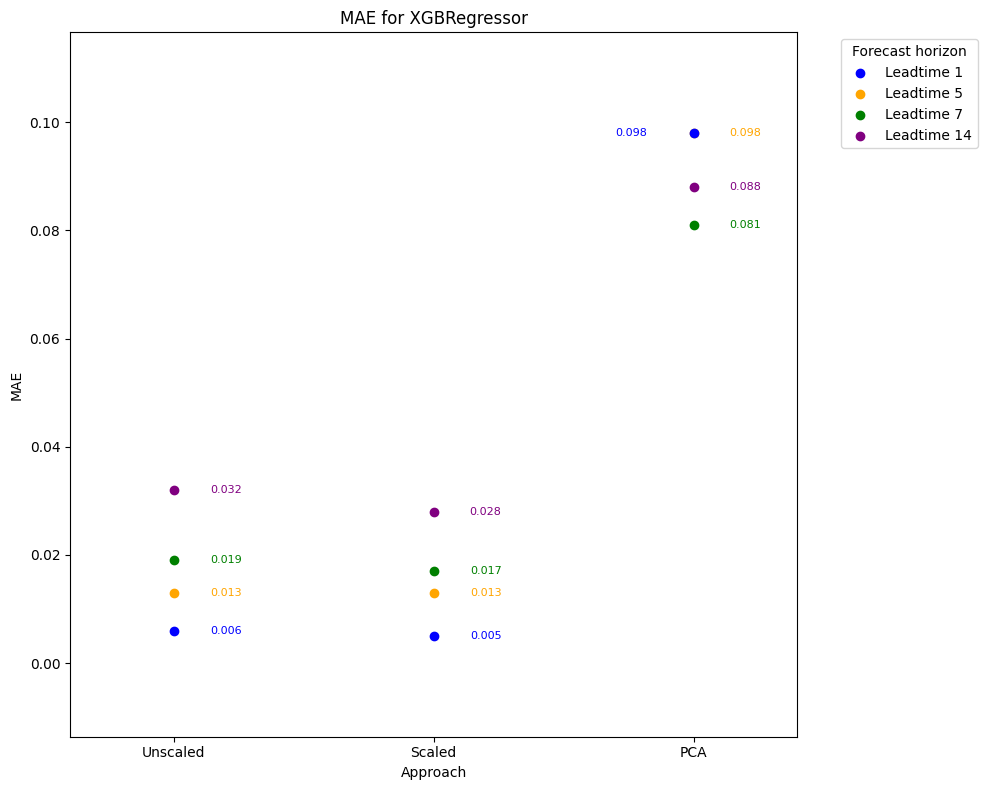

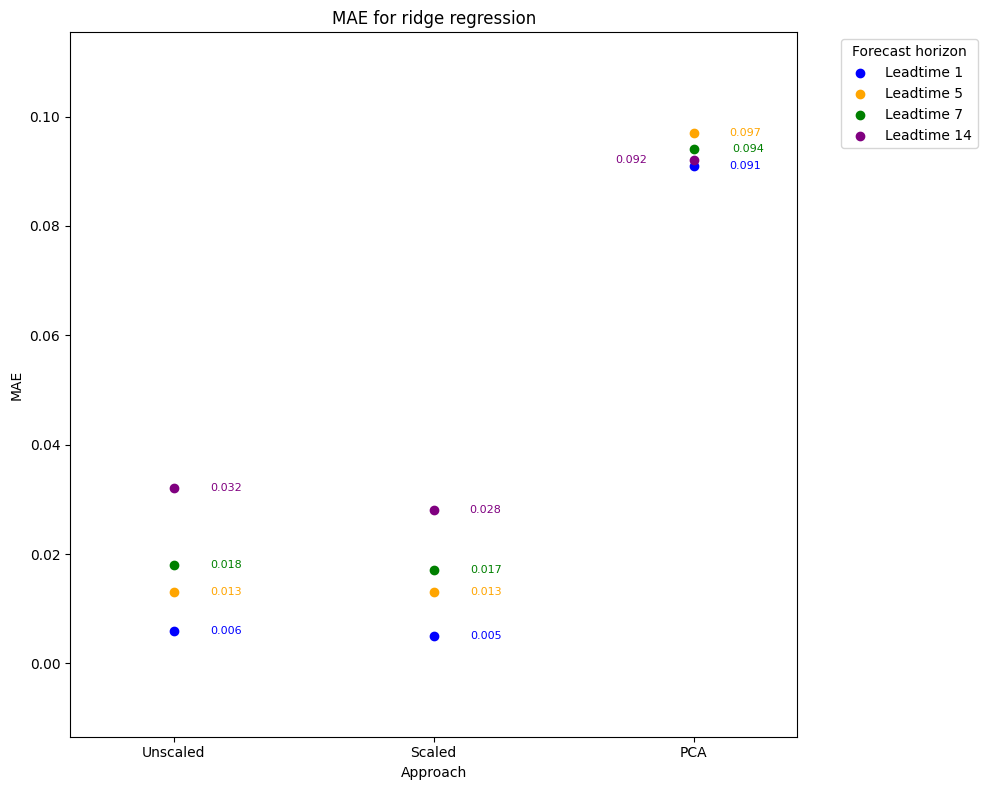

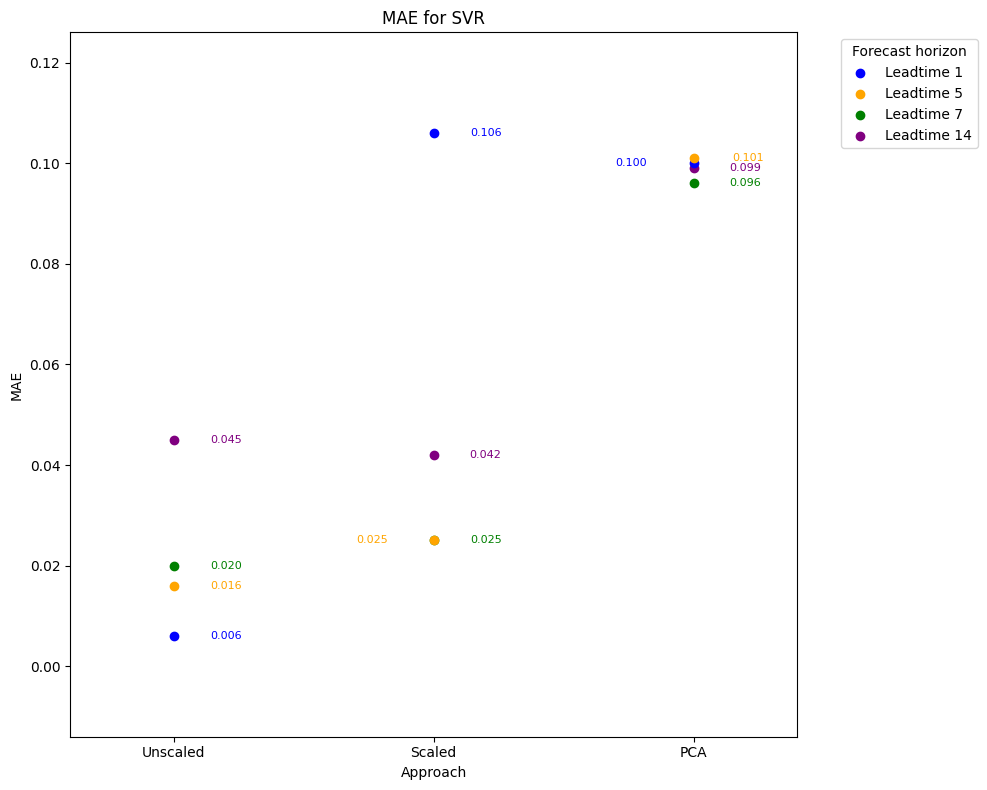

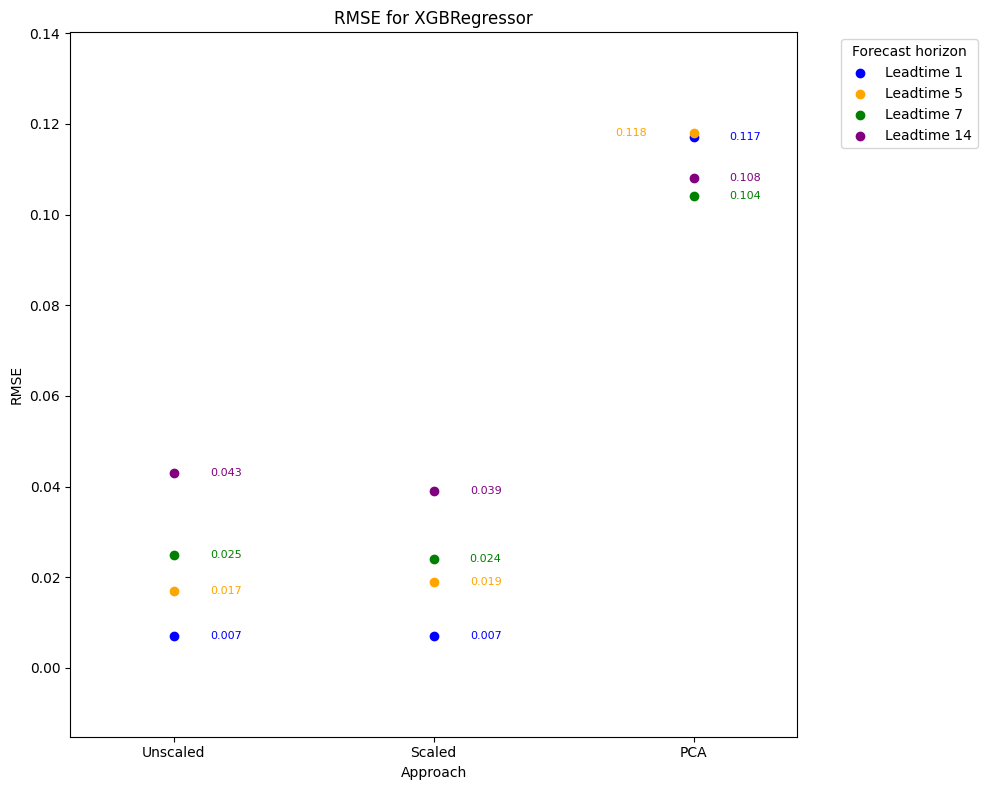

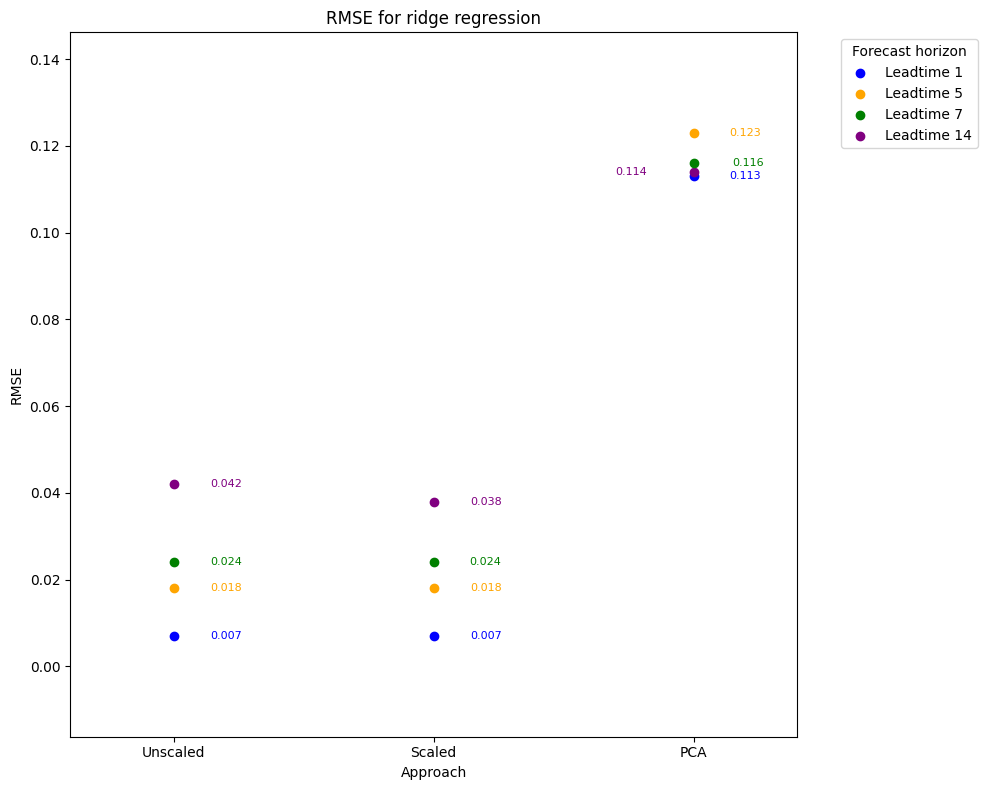

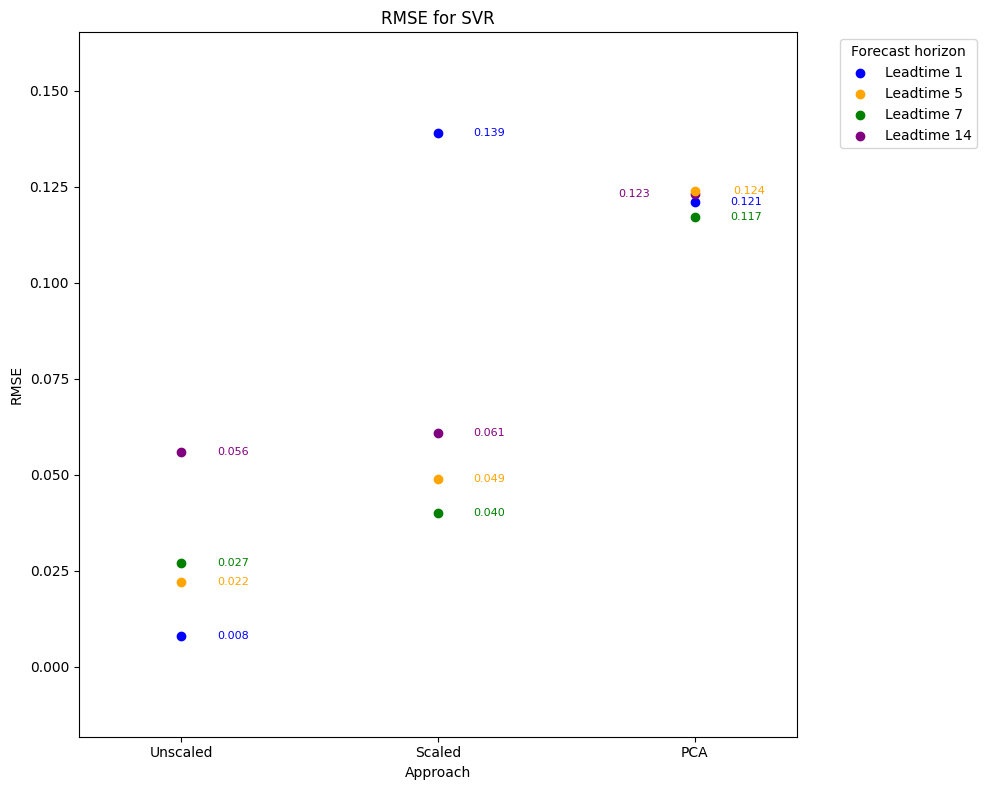

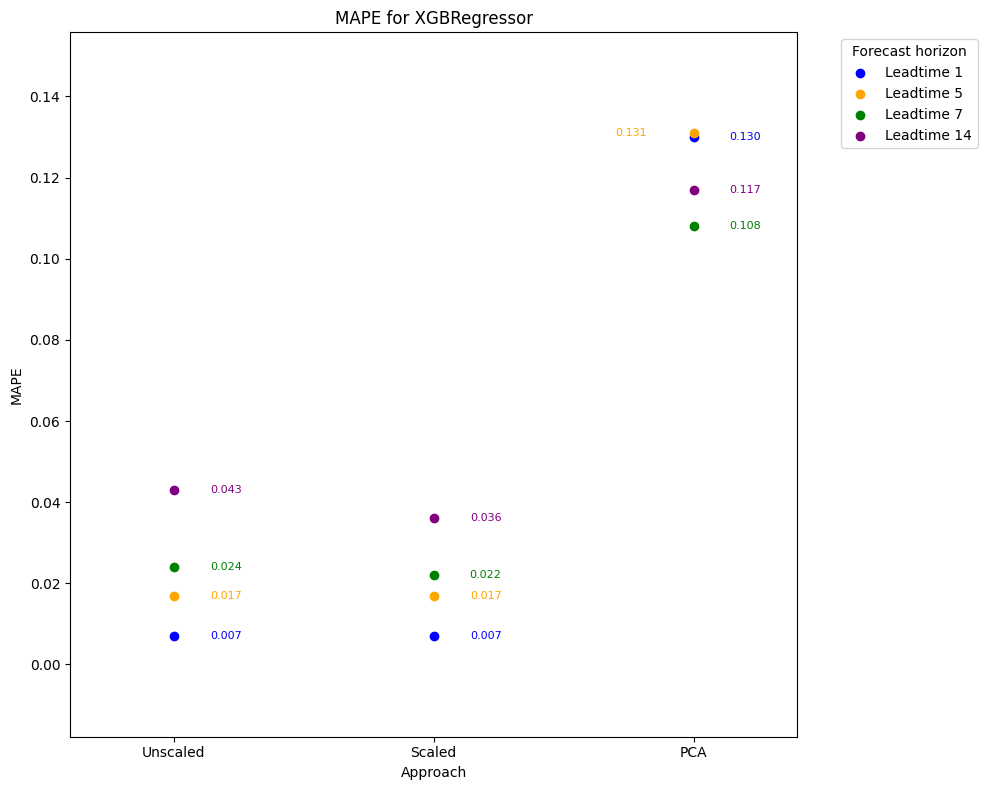

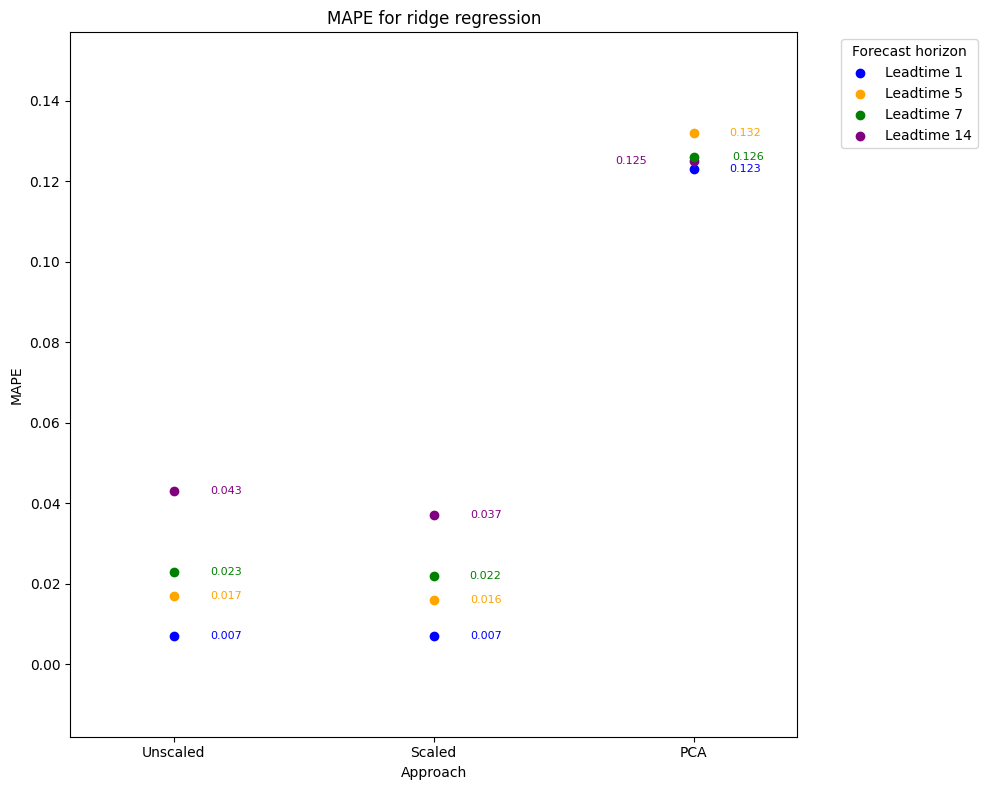

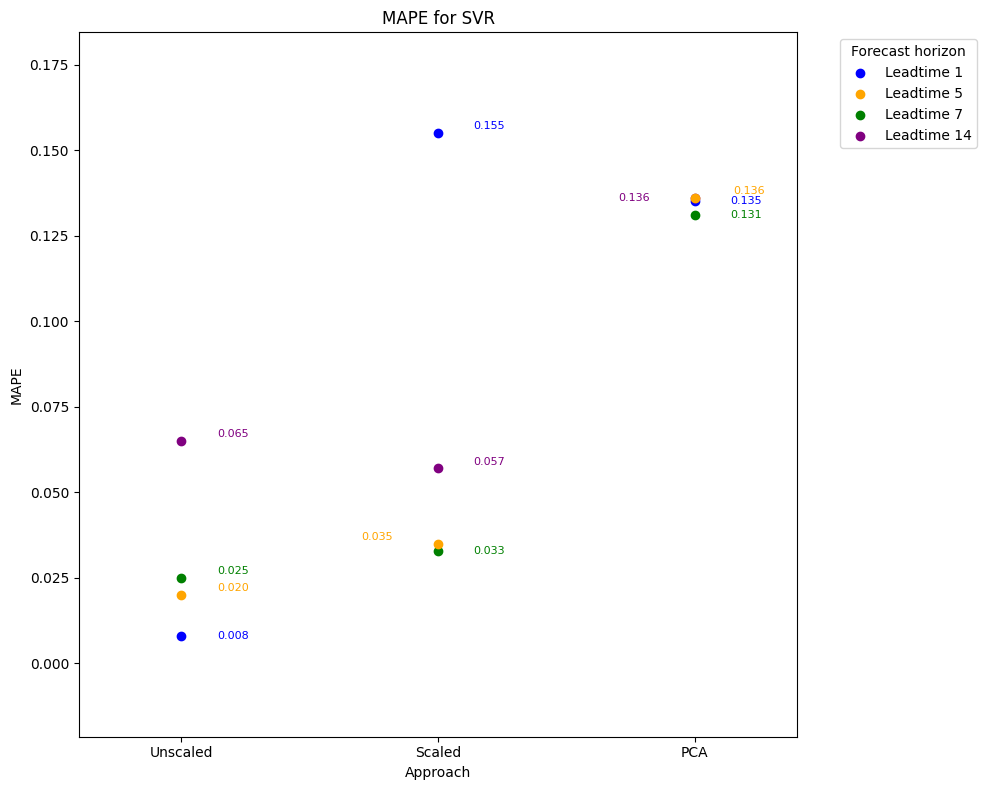

In [33]:
def performance_plots(df):


    all_xgb = df[df['Model'] == 'XGBRegressor']
    all_ridge = df[df['Model'] == 'ridge regression']
    all_svr = df[df['Model'] == 'SVR']
    frames = [all_xgb, all_ridge, all_svr]
    
    # Define colors for each lead time
    lead_colors = {1: 'blue', 5: 'orange', 7: 'green', 14: 'purple'}
    
    # Mapping approaches to numeric positions
    approaches = ['Unscaled', 'Scaled', 'PCA']
    approach_positions = {approach: i for i, approach in enumerate(approaches)}
    
    # Threshold for small differences
    threshold = 0.003

    for frame in frames:
        plt.figure(figsize=(10, 8))
        
        # Use a set to track which lead times have been added to the legend
        used_leads = set()
        
        for approach in approaches:
            temp_df = frame[frame['Approach'] == approach]
            if temp_df.empty:
                continue
            
            x_position = approach_positions[approach]
            
            # Sort the DataFrame by MAE for this approach
            temp_df = temp_df.sort_values(by='MAE').reset_index(drop=True)
            
            # Alternate offsets for points based on the threshold
            last_y = None
            offset_sign = -6  
            
            for i, (y, lead) in enumerate(zip(temp_df['MAE'], temp_df['Leadtime'])):
                if last_y is not None and abs(y - last_y) < threshold:
                    offset = offset_sign * 0.05
                    align = 'right' if offset_sign == -1 else 'left'
                    offset_sign *= -.5  # Alternate sign
                else:
                    offset = 0.2
                    align = 'center'
                
                last_y = y
                
                # Only add a label for the legend if the lead time hasn't been added yet
                label = f'Leadtime {lead}' if lead not in used_leads else ""
                if label:
                    used_leads.add(lead)
                
                plt.scatter(x_position, y, color=lead_colors[lead], label=label)
                plt.text(x_position + offset, y, f'{y:.3f}', color=lead_colors[lead], ha=align, va='center', fontsize=8)
        
        # Adjust x-axis ticks and labels
        plt.xticks(range(len(approaches)), approaches)
        plt.title(f"MAE for {frame['Model'].iloc[0]}")
        plt.xlabel("Approach")
        plt.ylabel("MAE")
        plt.margins(x=0.2, y=0.2)
        # Position legend outside the plot to the right
        plt.legend(title="Forecast horizon", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()

    for frame in frames:
        plt.figure(figsize=(10, 8))
        
        # Use a set to track which lead times have been added to the legend
        used_leads = set()
        
        for approach in approaches:
            temp_df = frame[frame['Approach'] == approach]
            if temp_df.empty:
                continue
            
            x_position = approach_positions[approach]
            
            # Sort the DataFrame by MAE for this approach
            temp_df = temp_df.sort_values(by='RMSE').reset_index(drop=True)
            
            # Alternate offsets for points based on the threshold
            last_y = None
            offset_sign = -6  # Start with -1 for alternating logic
            
            for i, (y, lead) in enumerate(zip(temp_df['RMSE'], temp_df['Leadtime'])):
                if last_y is not None and abs(y - last_y) < threshold:
                    offset = offset_sign * 0.05
                    align = 'right' if offset_sign == -1 else 'left'
                    offset_sign *= -.5  # Alternate sign
                else:
                    offset = 0.2
                    align = 'center'
                
                last_y = y
                
                # Only add a label for the legend if the lead time hasn't been added yet
                label = f'Leadtime {lead}' if lead not in used_leads else ""
                if label:
                    used_leads.add(lead)
                
                plt.scatter(x_position, y, color=lead_colors[lead], label=label)
                plt.text(x_position + offset, y, f'{y:.3f}', color=lead_colors[lead], ha=align, va='center', fontsize=8)
        
        # Adjust x-axis ticks and labels
        plt.xticks(range(len(approaches)), approaches)
        plt.title(f"RMSE for {frame['Model'].iloc[0]}")
        plt.xlabel("Approach")
        plt.ylabel("RMSE")
        plt.margins(x=0.2, y=0.2)
        # Position legend outside the plot to the right
        plt.legend(title="Forecast horizon", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()

    for frame in frames:
        plt.figure(figsize=(10, 8))
        
        # Use a set to track which lead times have been added to the legend
        used_leads = set()
        
        for approach in approaches:
            temp_df = frame[frame['Approach'] == approach]
            if temp_df.empty:
                continue

            x_position = approach_positions[approach]

            # Sort the DataFrame by MAPE for this approach
            temp_df = temp_df.sort_values(by='MAPE').reset_index(drop=True)

            # Alternate offsets for points based on the threshold
            last_y = None
            offset_sign = -6  # Start with -1 for alternating logic
            height_offset = 0
            for i, (y, lead) in enumerate(zip(temp_df['MAPE'], temp_df['Leadtime'])):
                # Check if current and previous y-values are close enough
                if last_y is not None and abs(y - last_y) < threshold:
                    offset = offset_sign * 0.05
                    align = 'right' if offset_sign == -1 else 'left'
                    offset_sign *= -0.5  # Alternate sign
                else:
                    offset = 0.2
                    align = 'center'
                
                last_y = y

                # Check if model is SVR, lead is 5, and the approach is Blended
                if 'SVR' in frame['Model'].values and lead == 5 and 'PCA' in frame['Approach'].values:
                    height_offset = 0.002  # Apply height offset only for this specific condition

                # Only add a label for the legend if the lead time hasn't been added yet
                label = f'Leadtime {lead}' if lead not in used_leads else ""
                if label:
                    used_leads.add(lead)

                plt.scatter(x_position, y, color=lead_colors[lead], label=label)
                plt.text(x_position + offset, y + height_offset, f'{y:.3f}', color=lead_colors[lead], ha=align, va='center', fontsize=8)

        # Adjust x-axis ticks and labels
        plt.xticks(range(len(approaches)), approaches)
        plt.title(f"MAPE for {frame['Model'].iloc[0]}")
        plt.xlabel("Approach")
        plt.ylabel("MAPE")
        plt.margins(x=0.2, y=0.2)
        # Position legend outside the plot to the right
        plt.legend(title="Forecast horizon", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()



performance_plots(all_df)

In [86]:
np.unique(residuals_scale[residuals_scale['extreme']==True]['Date visit'])



array(['2023-11-28T00:00:00.000000000', '2023-11-29T00:00:00.000000000',
       '2023-11-30T00:00:00.000000000', '2023-12-04T00:00:00.000000000',
       '2023-12-05T00:00:00.000000000', '2023-12-06T00:00:00.000000000',
       '2023-12-07T00:00:00.000000000', '2023-12-11T00:00:00.000000000',
       '2023-12-14T00:00:00.000000000', '2023-12-18T00:00:00.000000000',
       '2023-12-19T00:00:00.000000000', '2023-12-20T00:00:00.000000000',
       '2023-12-21T00:00:00.000000000', '2023-12-22T00:00:00.000000000',
       '2024-01-19T00:00:00.000000000', '2024-01-29T00:00:00.000000000',
       '2024-01-30T00:00:00.000000000', '2024-06-10T00:00:00.000000000',
       '2024-06-11T00:00:00.000000000', '2024-06-12T00:00:00.000000000',
       '2024-06-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [35]:
def error_analysis(df,extensive=False):

     # Define colors for each lead time
     #Can be made different, but they will just overcolor the previous one
     #opacity can be set at varying rates but it makes interpretation more difficult
     #I keep the lead time distinction to have the percentage for each horizon included in the plot
    lead_colors = {1: 'orange', 5: 'orange', 7: 'orange', 14: 'orange'}
    alphas={1:0.9,5:0.7,7:0.5,14:0.3}
    for algo in np.unique(df['Model']):
        filter = df[df['Model'] == algo]
        std_dev = filter.groupby('Leadtime')['difference'].std()
        median=filter.groupby('Leadtime')['difference'].median()
        print('Median')
        print(filter.groupby('Leadtime')['difference'].median())
        print(filter.groupby('Leadtime')['difference'].mean())
        impossible = filter['extreme'].sum()/filter.shape[0]*100
        #Plot the differences for the selected model and lead time
        plt.figure(figsize=(10, 6))
        plt.scatter(filter['Leadtime'], filter['difference'], marker='o', color='b')
        #plt.plot(std_dev.index, std_dev.values, marker='x', linestyle='--', color='r', label='Standard Deviation')
        plt.scatter(median.index,median.values,label="Median",color='r')
        plt.xlabel('Forecast horizon')
        plt.ylabel('Difference (Truth - Predictions)')
        plt.title(f'Residuals for {algo} with {np.round(impossible,2)}% of predictions above 2 standard deviations')
        plt.show()
        
        if extensive == True:
            plt.figure(figsize=(10, 6))
            temp_df=filter[filter['Leadtime']==1]
            plt.plot(temp_df['Date visit'],temp_df['true'],label='True occupancy',color='b')
            plt.xlabel('Date')
            plt.ylabel('Occupancy')
            plt.title(f'True occupancy and extreme {algo} residuals')
            
            model_extreme=filter[filter['extreme']==True]
            for lead in np.unique(model_extreme['Leadtime']):
                #calculates extreme value percentage for each forecast horizon
                impossible = np.round(model_extreme[model_extreme['Leadtime']==lead]['extreme'].sum()/filter.shape[0]*100,2)
                #Drops duplicates for same day, same horizon to declutter plotting
                model_extreme2=model_extreme.drop_duplicates(subset=['Leadtime','Date visit'])
                
                plt.scatter(model_extreme2['Date visit'],model_extreme2['predicted'],color=lead_colors[lead], label=f'Forecast horizon {lead} with {impossible}% extreme residuals',marker='.')
                plt.legend()
            plt.show()
   




Median
Leadtime
1     0.004491
5     0.004491
7     0.004491
14    0.004491
Name: difference, dtype: float64
Leadtime
1     0.011546
5     0.011546
7     0.011546
14    0.011546
Name: difference, dtype: float64


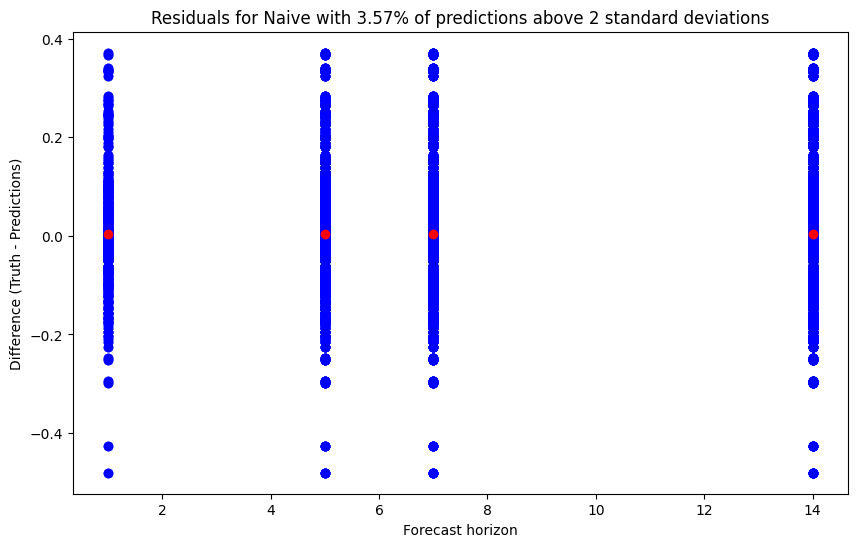

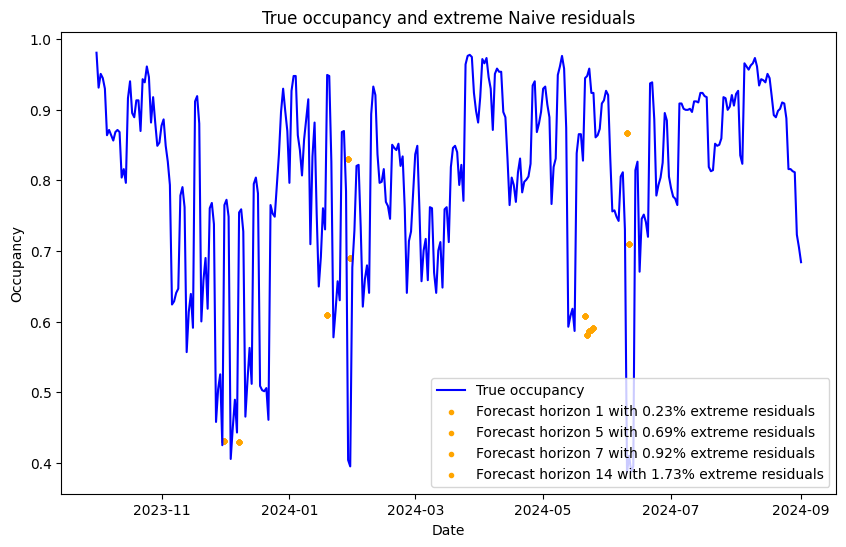

In [36]:
error_analysis(residuals_naive,True)


Median
Leadtime
1    -0.001801
5     0.002191
7     0.001482
14   -0.021850
Name: difference, dtype: float64
Leadtime
1    -0.000290
5     0.005621
7     0.006063
14   -0.020980
Name: difference, dtype: float64


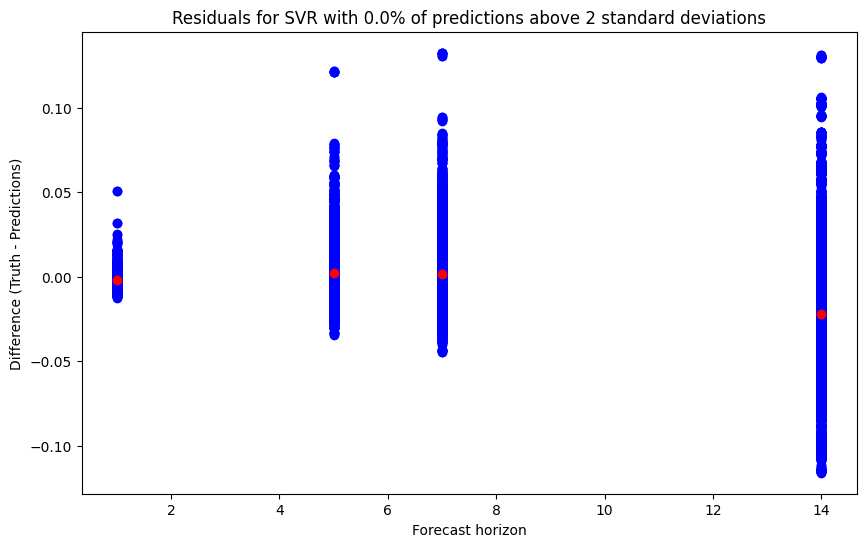

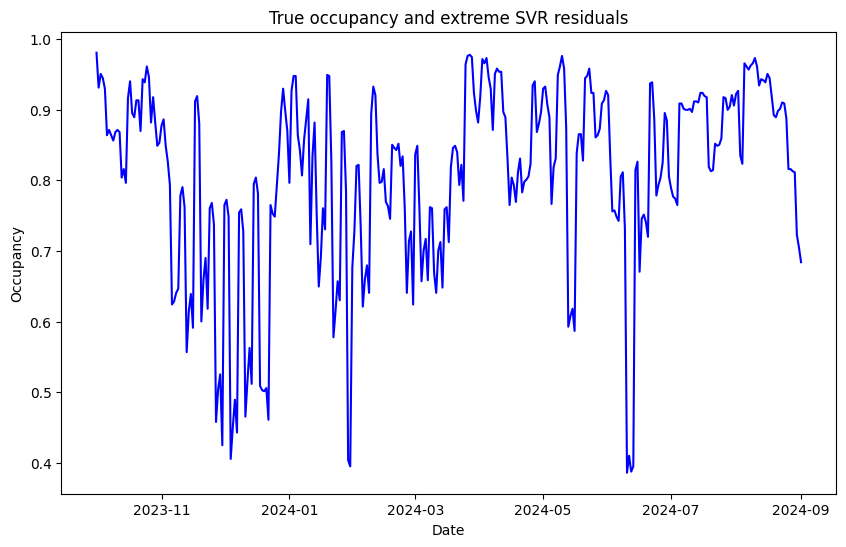

Median
Leadtime
1     0.001978
5     0.002697
7     0.001864
14   -0.007422
Name: difference, dtype: float64
Leadtime
1     0.002301
5     0.003710
7     0.004183
14   -0.006088
Name: difference, dtype: float64


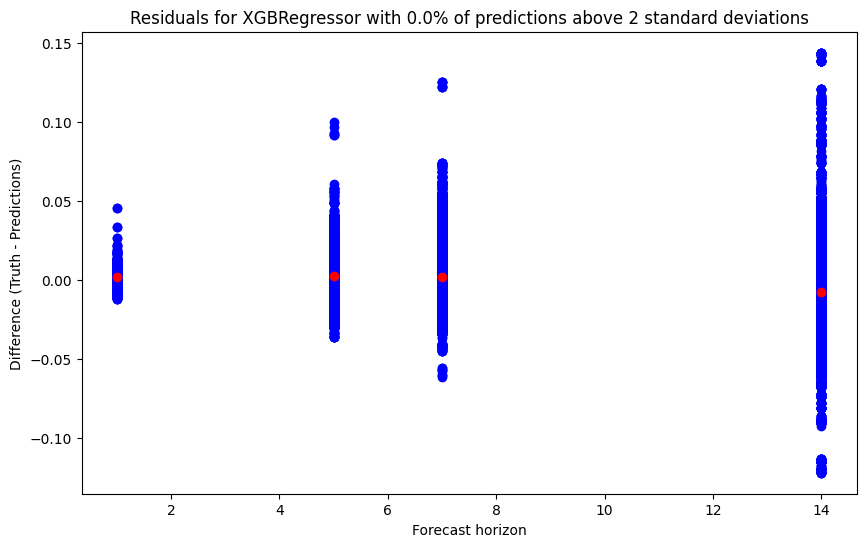

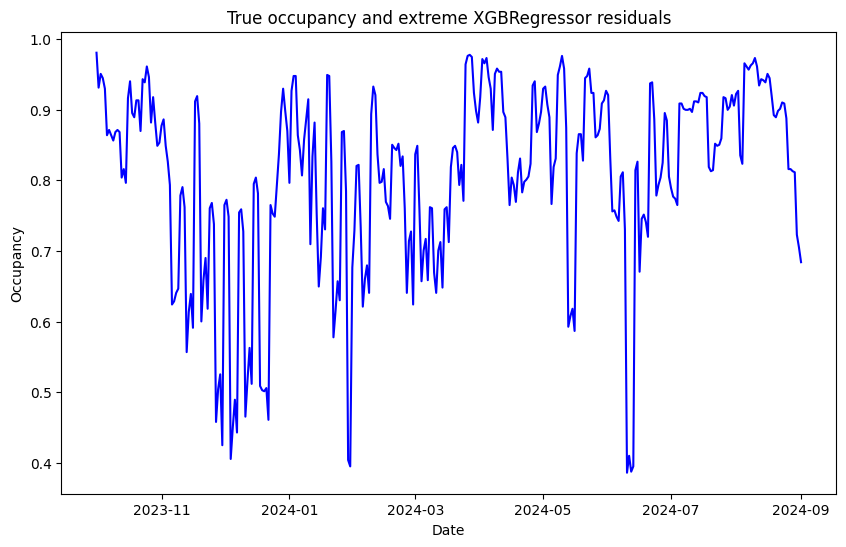

Median
Leadtime
1     0.001759
5     0.005650
7     0.006243
14   -0.005531
Name: difference, dtype: float64
Leadtime
1     0.003514
5     0.008714
7     0.010320
14   -0.001381
Name: difference, dtype: float64


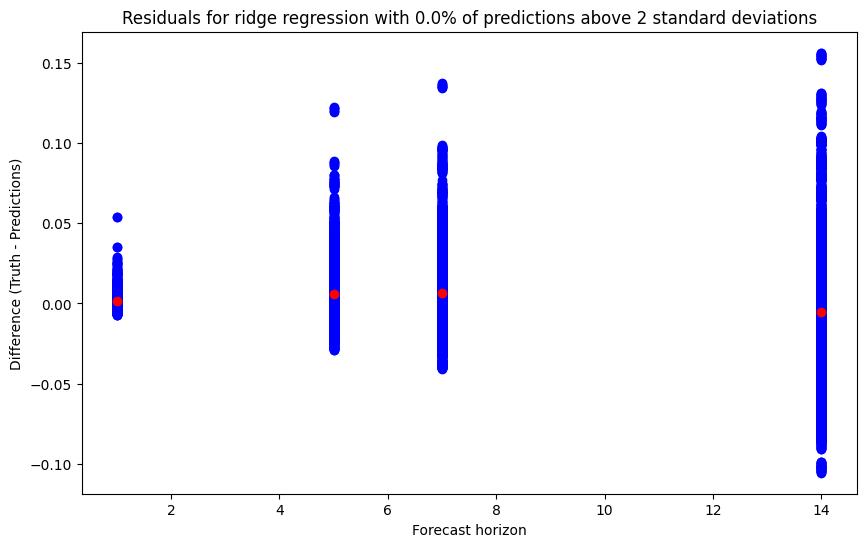

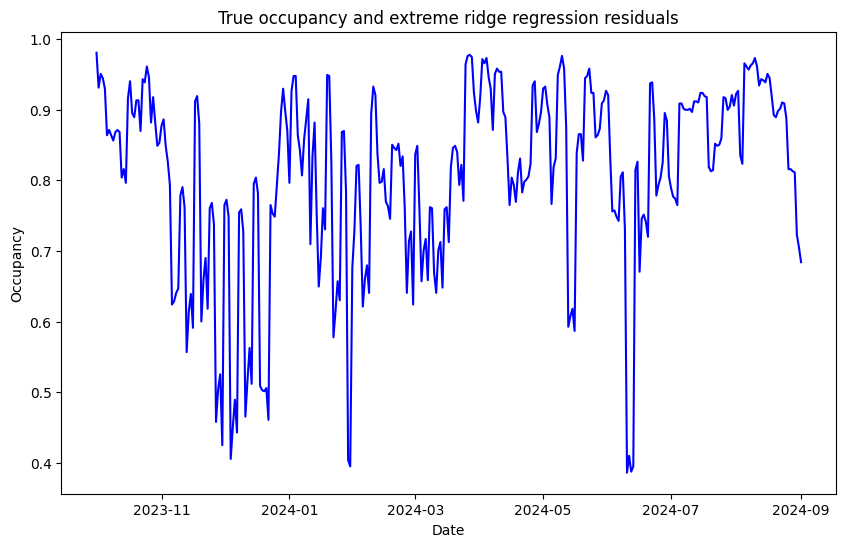

In [37]:
error_analysis(residuals_no_weather,True)

Median
Leadtime
1    -0.002318
5     0.000933
7     0.000871
14   -0.026411
Name: difference, dtype: float64
Leadtime
1    -0.000884
5     0.004020
7     0.004652
14   -0.026242
Name: difference, dtype: float64


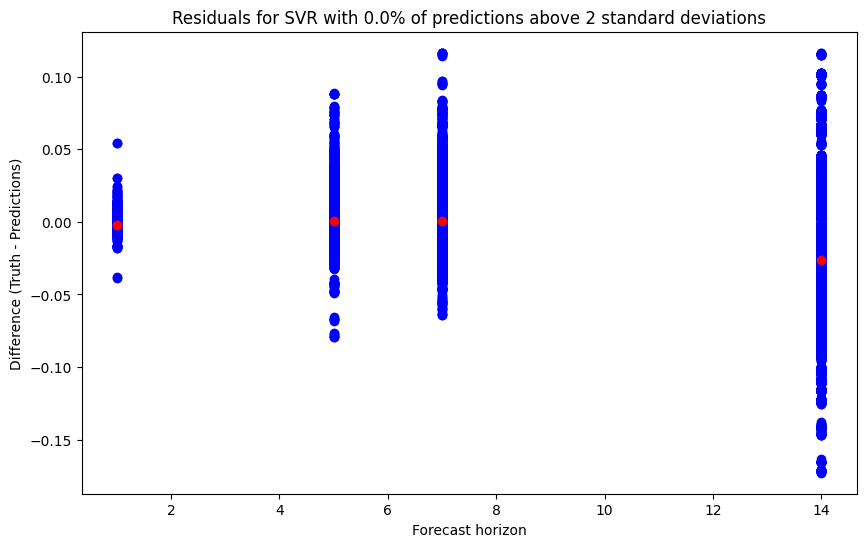

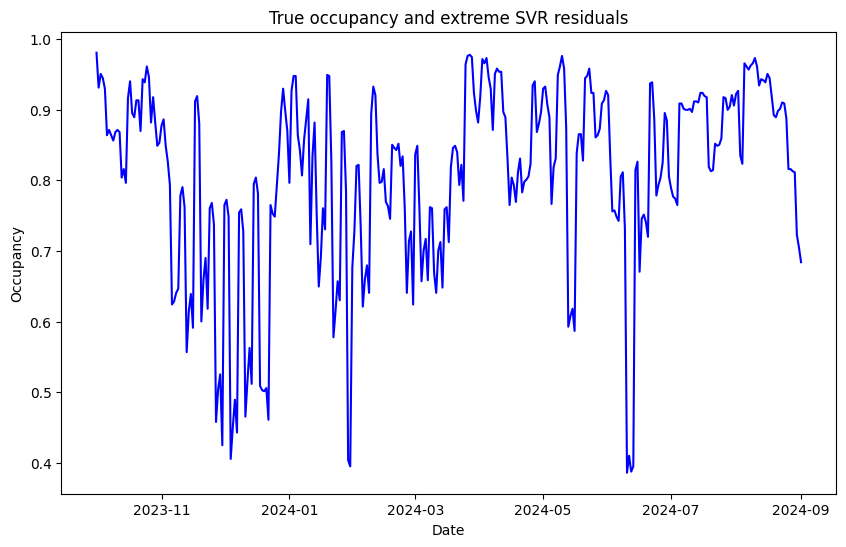

Median
Leadtime
1     0.002077
5     0.001878
7     0.001121
14   -0.008792
Name: difference, dtype: float64
Leadtime
1     0.002482
5     0.002940
7     0.005171
14   -0.005236
Name: difference, dtype: float64


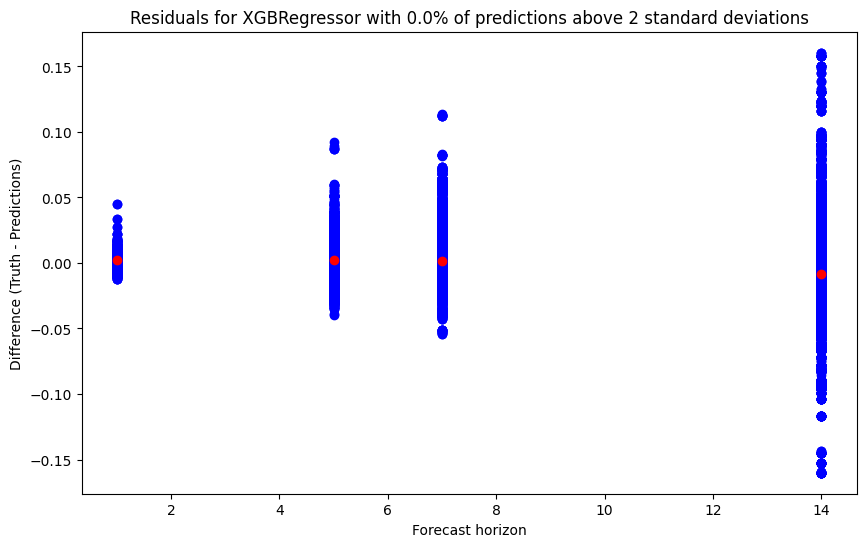

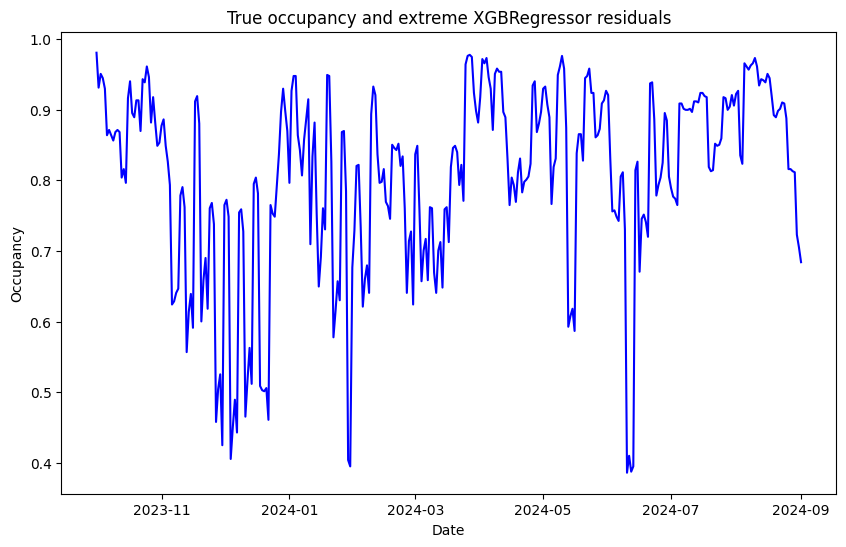

Median
Leadtime
1     0.002077
5     0.001994
7     0.001588
14   -0.008815
Name: difference, dtype: float64
Leadtime
1     0.002482
5     0.003158
7     0.004818
14   -0.006167
Name: difference, dtype: float64


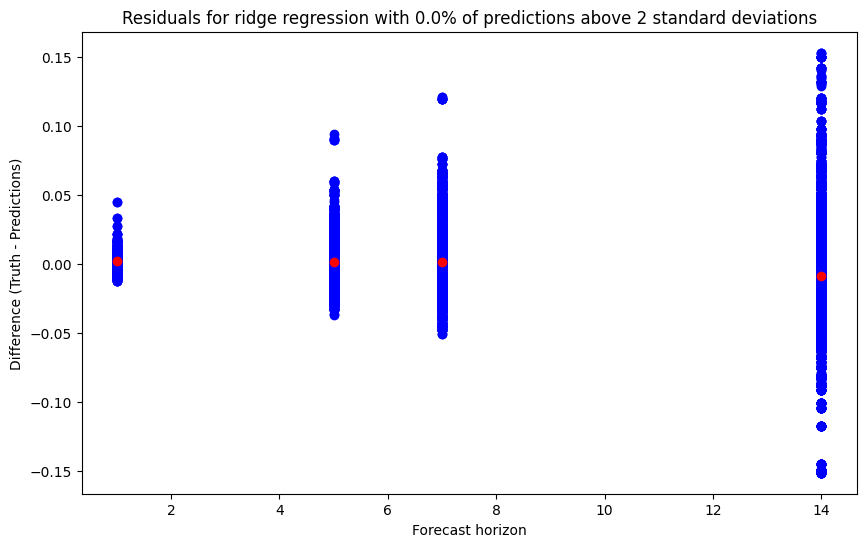

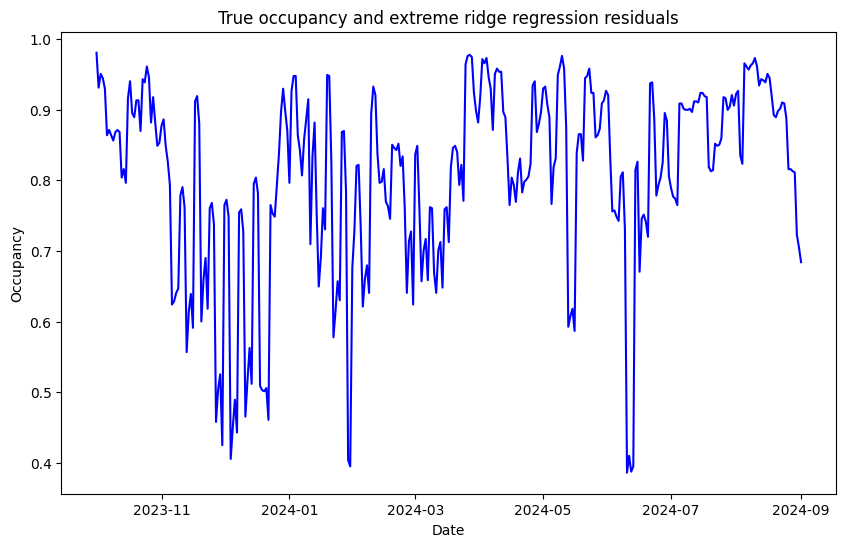

In [17]:
error_analysis(residuals_unscaled,True)


Median
Leadtime
1     0.040615
5     0.006868
7     0.006736
14    0.006507
Name: difference, dtype: float64
Leadtime
1     0.004236
5     0.007857
7     0.008154
14    0.006875
Name: difference, dtype: float64


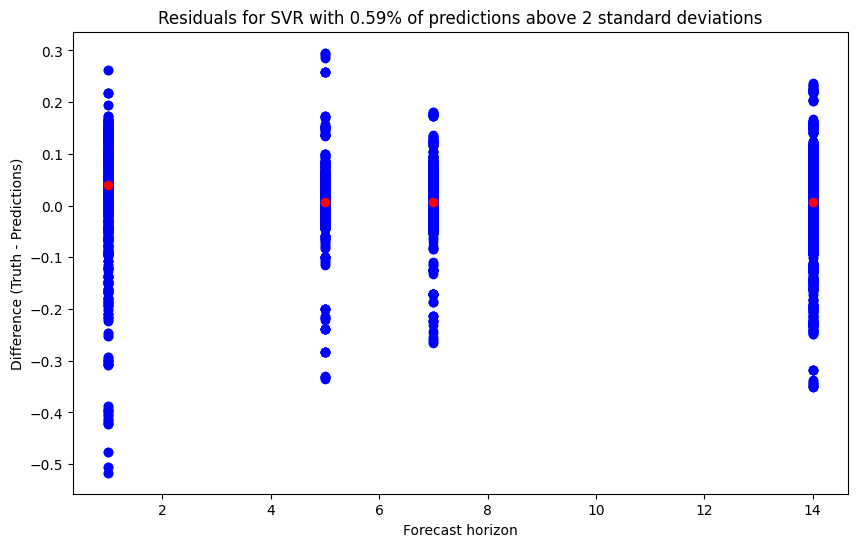

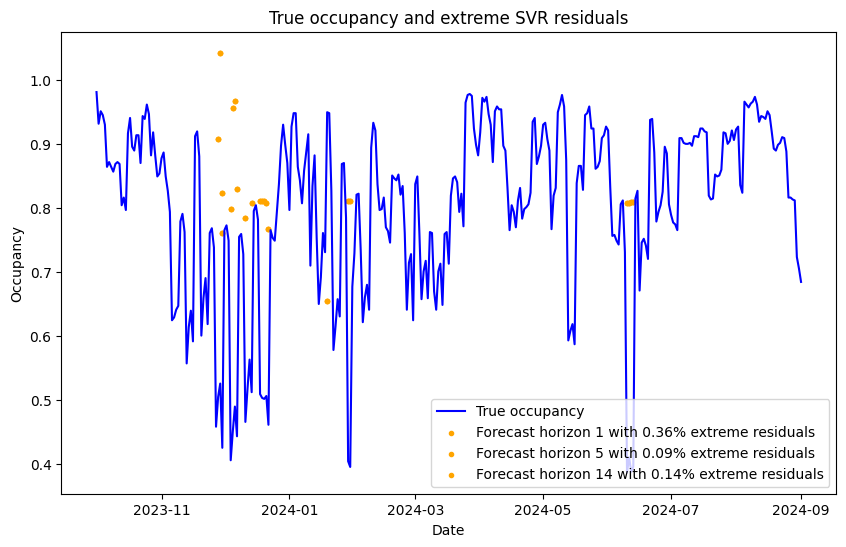

Median
Leadtime
1     0.001365
5     0.003693
7     0.004382
14    0.003850
Name: difference, dtype: float64
Leadtime
1     0.002143
5     0.006307
7     0.006861
14    0.004794
Name: difference, dtype: float64


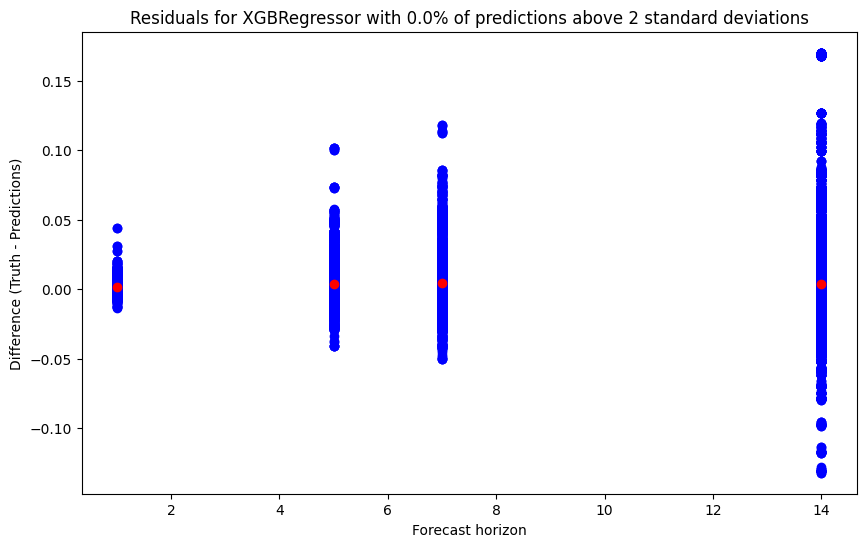

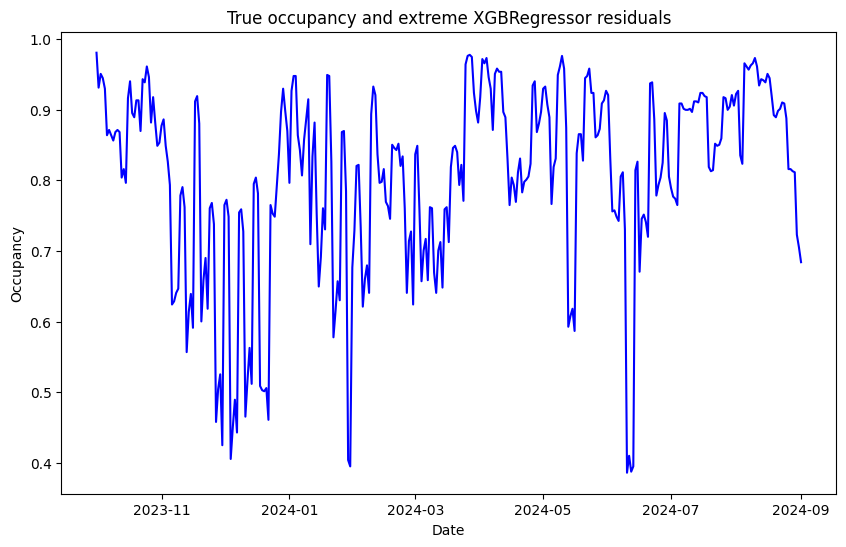

Median
Leadtime
1     0.001365
5     0.003262
7     0.003428
14    0.002006
Name: difference, dtype: float64
Leadtime
1     0.002143
5     0.005954
7     0.005950
14    0.002220
Name: difference, dtype: float64


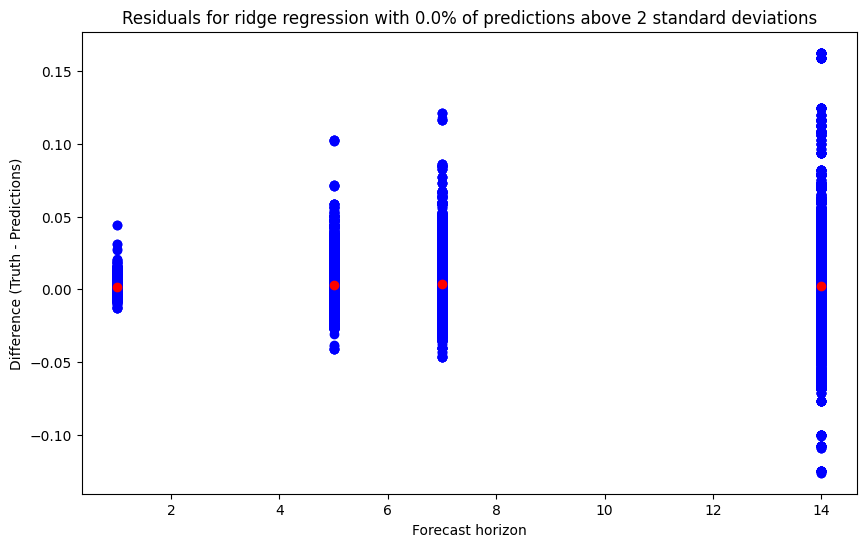

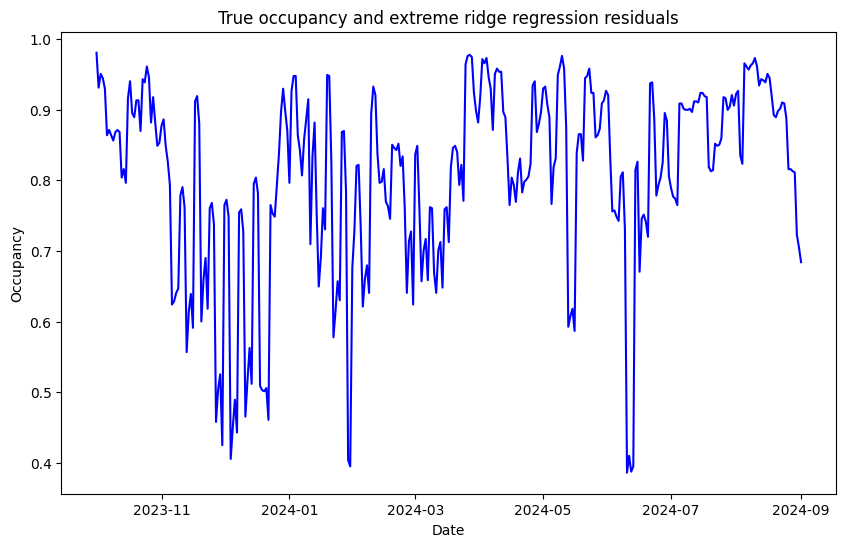

In [18]:
error_analysis(residuals_scale,True)

Median
Leadtime
1     0.060277
5     0.065127
7     0.058967
14    0.059108
Name: difference, dtype: float64
Leadtime
1     0.044039
5     0.043991
7     0.039696
14    0.039235
Name: difference, dtype: float64


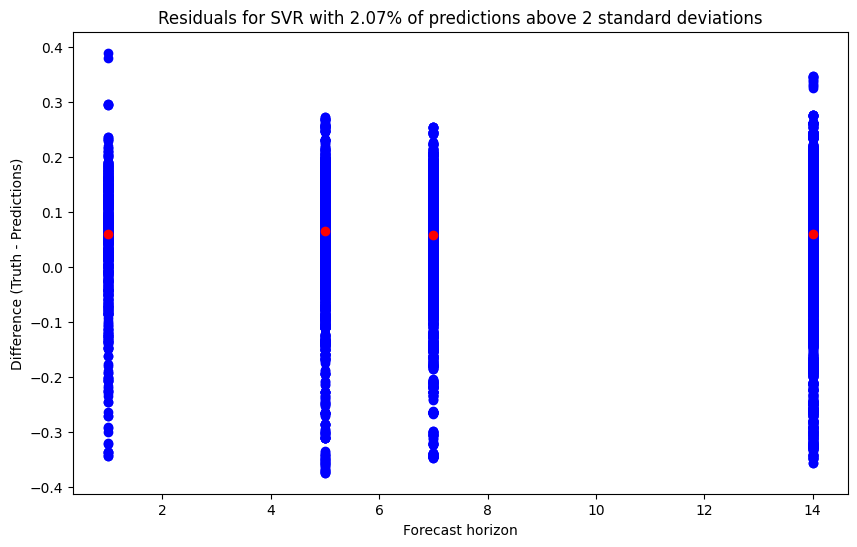

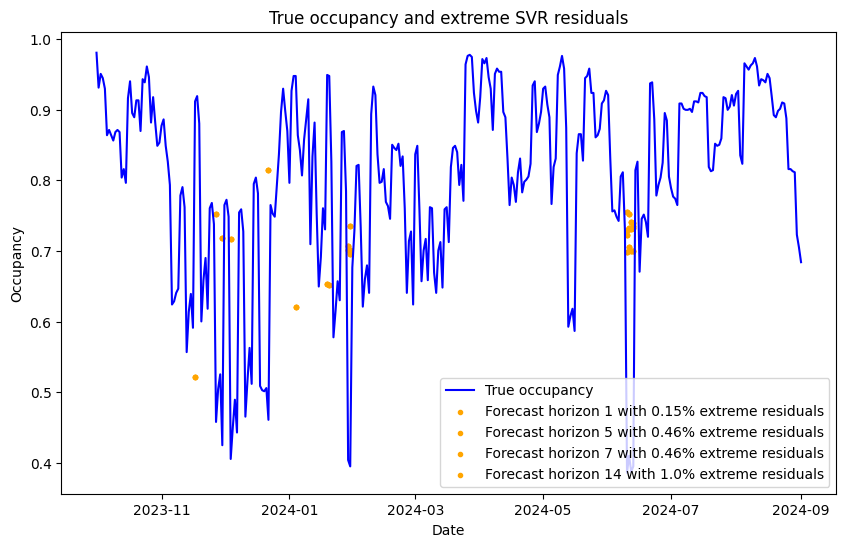

Median
Leadtime
1     0.074467
5     0.074374
7     0.042826
14    0.057140
Name: difference, dtype: float64
Leadtime
1     0.051788
5     0.051589
7     0.041619
14    0.044082
Name: difference, dtype: float64


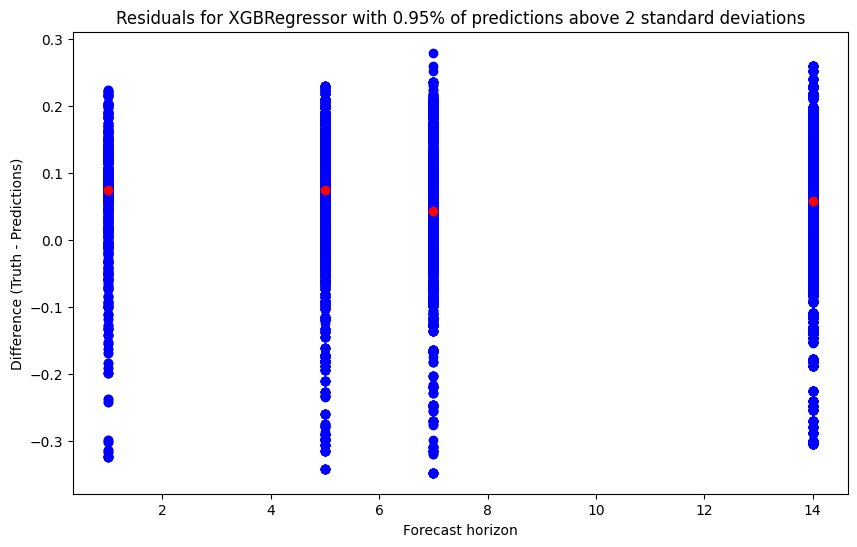

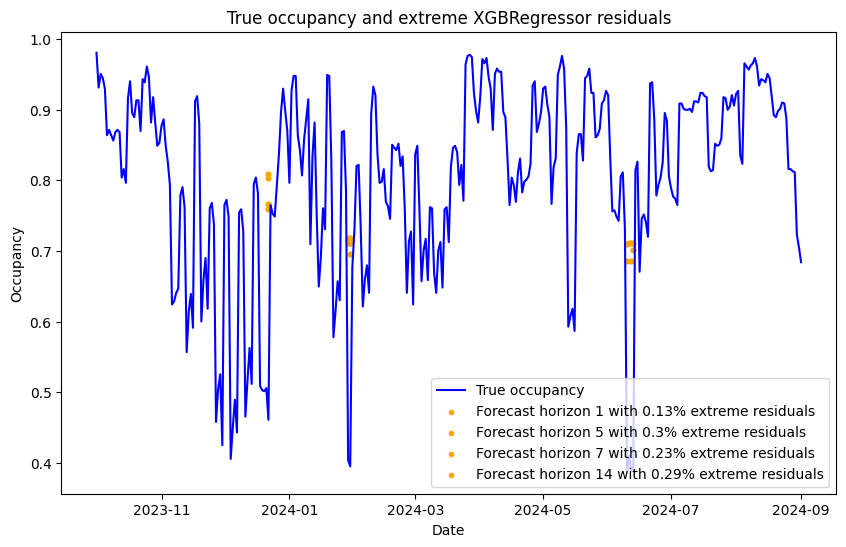

Median
Leadtime
1     0.053421
5     0.056044
7     0.055988
14    0.054400
Name: difference, dtype: float64
Leadtime
1     0.041027
5     0.041135
7     0.043107
14    0.041614
Name: difference, dtype: float64


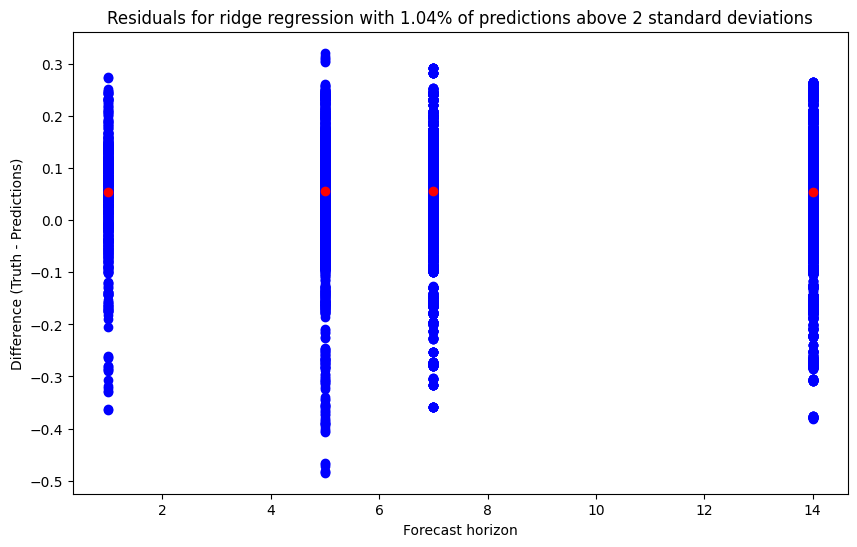

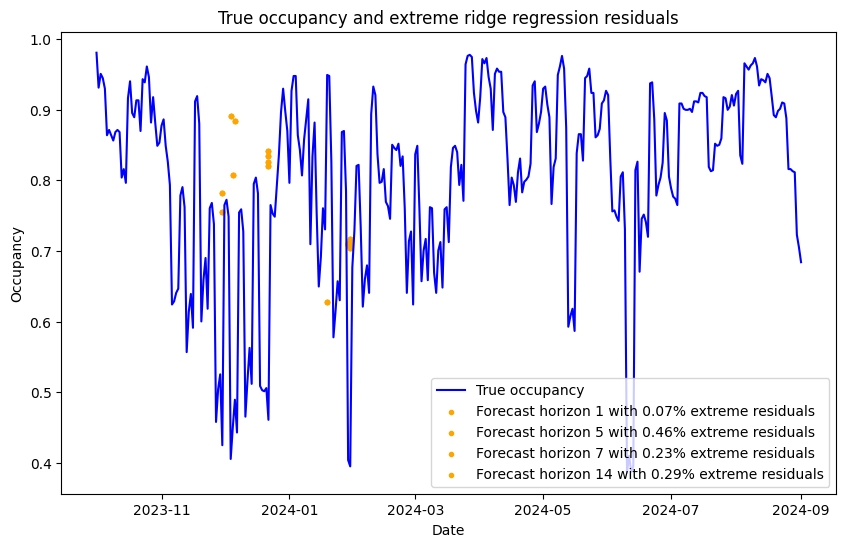

In [38]:
error_analysis(residuals_blended,True)